# Imports and preinstallation

## Install libs

In [0]:
!pip install eli5

    100% |████████████████████████████████| 102kB 2.7MB/s 


In [0]:
!pip install plotly --upgrade

Requirement already up-to-date: plotly in /usr/local/lib/python3.6/dist-packages (3.6.1)


Fix for 'title' has invalid value inside 'layout'

In [0]:
!pip install clint

  Stored in directory: /root/.cache/pip/wheels/4f/e9/45/223565e5b1a4b09e12c6de6f8ba7c2c0e9127dec17cf830f83
  Stored in directory: /root/.cache/pip/wheels/58/54/ea/d995d18af68c057eb76b87b02c92bc66ac34d360ef141780f4
Successfully built clint args


In [0]:
!pip install utils

## Imports

In [0]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from skimage.measure import compare_ssim as ssim
import skimage
import tarfile
import sklearn.utils
import sklearn as skl
import IPython.display as ipd
import requests
import sys
import zipfile
import pandas as pd
import ast
import librosa
import librosa.display
from PIL import Image
import numpy as np
from sklearn import manifold, datasets, decomposition, ensemble, discriminant_analysis, random_projection
from sklearn.model_selection import train_test_split
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go
from time import time
import IPython
import xgboost as xgb
import scipy as sc
from keras import models, layers, optimizers, utils, losses, callbacks, regularizers
import tensorflow
import csv
import google.colab as gc
import seaborn as sns
import itertools
from sklearn.metrics import confusion_matrix
import concurrent
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
import eli5
from eli5.sklearn import PermutationImportance

Using TensorFlow backend.


## Help functions

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
#drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
example_track_id = 55718
music_dir = 'fma_small'
fma_data_file = '/content/drive/My Drive/fma_v3.csv'
fma_windowed_data_file = '/content/drive/My Drive/fma_v3_windowed.csv'

In [0]:
np.random.seed(42)
tensorflow.set_random_seed(42)

In [0]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

#IPython.get_ipython().events.unregister('pre_run_cell', configure_plotly_browser_state)
init_notebook_mode(connected=True)

In [0]:
def download(url, filename):
    with open(filename, 'wb') as f:
        response = requests.get(url, stream=True)
        total = response.headers.get('content-length')

        if total is None:
            f.write(response.content)
        else:
            sys.stdout.write('Downloading {} of size {} from {}\n'.format(
                filename, total, url))
            downloaded = 0
            total = int(total)
            for data in response.iter_content(chunk_size=max(int(total/1000), 1024*1024)):
                downloaded += len(data)
                f.write(data)
                done = int(50*downloaded/total)
                sys.stdout.write('\r[{}{}]'.format('█' * done, '.' * (50-done)))
                sys.stdout.flush()
    sys.stdout.write('\nDone\n')

In [0]:
def load(filepath):

    filename = os.path.basename(filepath)

    if 'features' in filename:
        return pd.read_csv(filepath, index_col=0, header=[0, 1, 2])

    if 'echonest' in filename:
        return pd.read_csv(filepath, index_col=0, header=[0, 1, 2])

    if 'genres' in filename:
        return pd.read_csv(filepath, index_col=0)

    if 'tracks' in filename:
        tracks = pd.read_csv(filepath, index_col=0, header=[0, 1])

        COLUMNS = [('track', 'tags'), ('album', 'tags'), ('artist', 'tags'),
                   ('track', 'genres'), ('track', 'genres_all')]
        for column in COLUMNS:
            tracks[column] = tracks[column].map(ast.literal_eval)

        COLUMNS = [('track', 'date_created'), ('track', 'date_recorded'),
                   ('album', 'date_created'), ('album', 'date_released'),
                   ('artist', 'date_created'), ('artist', 'active_year_begin'),
                   ('artist', 'active_year_end')]
        for column in COLUMNS:
            tracks[column] = pd.to_datetime(tracks[column])

        SUBSETS = ('small', 'medium', 'large')
        tracks['set', 'subset'] = tracks['set', 'subset'].astype(
                'category', categories=SUBSETS, ordered=True)

        COLUMNS = [('track', 'genre_top'), ('track', 'license'),
                   ('album', 'type'), ('album', 'information'),
                   ('artist', 'bio')]
        for column in COLUMNS:
            tracks[column] = tracks[column].astype('category')

        return tracks

In [0]:
def plot_history(history, title=''):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    epochs = range(1, len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss ' + title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy ' + title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Explore FMA

### Downloading various sizes of MP3-encoded audio data

In [0]:
download('https://os.unil.cloud.switch.ch/fma/fma_metadata.zip', 'fma_metadata.zip')
with zipfile.ZipFile('fma_metadata.zip', 'r') as zip_ref:
    zip_ref.extractall('')

[██████████████████████████████████████████████████]
Done


In [0]:
name = 'fma_small'
download('https://os.unil.cloud.switch.ch/fma/fma_small.zip', name + '.zip')

[██████████████████████████████████████████████████]
Done


In [0]:
with zipfile.ZipFile(name + '.zip', 'r') as zip_ref:
    zip_ref.extractall('')

### Reading data

In [0]:
tracks = load('fma_metadata/tracks.csv')
genres = load('fma_metadata/genres.csv')
#features = load('fma_metadata/features.csv')
#echonest = load('fma_metadata/echonest.csv')

tracks_data = tracks['track']

tracks.shape, genres.shape#, features.shape, echonest.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: FutureWarning:

specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead



((106574, 52), (163, 4))

# Processing audio

## Converting mp3

In [0]:
def extract_info(audio_fpath, audio_fname):
  y, sr = librosa.load(audio_fpath, sr=12000, mono=True)
  stft = np.abs(librosa.stft(y)) # np.abs(D[f, t]) is the magnitude of frequency bin f at frame t
  onset_env = librosa.onset.onset_strength(S=stft, sr=sr)
  tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)[0]
  mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=10).T, axis=0)  # 10 values
  rmse = np.mean(librosa.feature.rmse(y=y))
  zcr = np.mean(librosa.feature.zero_crossing_rate(y))
  rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
  spec_cent = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
  spec_bw = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
  chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T, axis=0)
  mel = np.mean(librosa.feature.melspectrogram(y, sr=sr).T, axis=0)
  spec_contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sr, n_bands=4).T, axis=0)
  tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr).T, axis=0) # tonal centroid features
  to_append = f'{audio_fname}'
  for v in mfccs:
    to_append += f',{v}'
  to_append += f',{tempo},{rmse},{zcr},{rolloff},{spec_cent},{spec_bw}'
  for v in spec_contrast:
    to_append += f',{v}'
  for v in chroma_stft:
    to_append += f',{v}'
  for v in mel:
    to_append += f',{v}'
  for v in tonnetz:
    to_append += f',{v}'
  return to_append

In [0]:
data_file = open(fma_data_file, 'w', newline='')
header = 'filename'
for i in range(10):
  header += f',mfcc{i}'
header += ',tempo,rmse,zcr,rolloff,spec_cent,spec_bw'
for i in range(5):
  header += f',spec_contrast{i}'
for i in range(12):
  header += f',chroma_stft{i}'
for i in range(128):
  header += f',mel{i}'
for i in range(6):
  header += f',tonnetz{i}'
header += ',label\n'

with data_file:
  data_file.write(header)

In [0]:
processed = []

In [0]:
data = pd.read_csv(fma_data_file)
processed = data['filename']

In [0]:
ok_cnt = 0
fail_cnt = 0
#count = 4
#ci = 0
for subdir, _, files in sorted(os.walk(music_dir)):
  for file in sorted(files):
    if file.lower().endswith('.mp3'):
      fpath = os.path.join(subdir, file)
      fname, _ = os.path.splitext(file) # (filename, extension)
      try:
        track_id = int(fname)
        if track_id in processed:
          continue
        genre = tracks_data[tracks_data.index.isin([track_id])]['genre_top'].values[0] 
        info = extract_info(fpath, fname) + f',{genre}\n'
        with open(fma_data_file, 'a', newline='') as data_file:
          data_file.write(info)
      except Exception as e:
        print('Fail', file, 'message', e, 'with path:', fpath)
        fail_cnt += 1
        continue
      ok_cnt += 1
      if ok_cnt % 100 == 0:
        print(f'OK {ok_cnt}')
      #ci += 1
      #if ci >= count:
        #break
    else:
      continue
  #if ci >= count:
    #break
print('Generated {}/{}'.format(ok_cnt, ok_cnt + fail_cnt))

OK 100
OK 200
OK 300
OK 400
OK 500
OK 600
OK 700
OK 800
OK 900
OK 1000
OK 1100
OK 1200
OK 1300
OK 1400
OK 1500
OK 1600
OK 1700
OK 1800
OK 1900
OK 2000
OK 2100
OK 2200
OK 2300
OK 2400
OK 2500
OK 2600
OK 2700
OK 2800
OK 2900
OK 3000
OK 3100
OK 3200
OK 3300
OK 3400
OK 3500
OK 3600
OK 3700
OK 3800
OK 3900
OK 4000
OK 4100
OK 4200
OK 4300
OK 4400
Fail 099134.mp3 message  with path: fma_small/099/099134.mp3
OK 4500
OK 4600
OK 4700
OK 4800
OK 4900
Fail 108925.mp3 message  with path: fma_small/108/108925.mp3
OK 5000
OK 5100
OK 5200
OK 5300
OK 5400
OK 5500
OK 5600
OK 5700
OK 5800
OK 5900
OK 6000
OK 6100
OK 6200
OK 6300
OK 6400
OK 6500
OK 6600
OK 6700
OK 6800
OK 6900
Fail 133297.mp3 message  with path: fma_small/133/133297.mp3
OK 7000
OK 7100
OK 7200
OK 7300
OK 7400
OK 7500
OK 7600
OK 7700
OK 7800
OK 7900
Generated 7997/8000


## Converting mp3

In [0]:
def window(data, window_size, offset):
  start = 0
  while start + window_size < len(data):
    yield start, start + window_size
    start += offset

In [0]:
def extract_info(audio_fpath, audio_fname, window_size):
  audio, sr = librosa.load(audio_fpath, sr=12000, mono=True)
  infos = []
  for (start, end) in window(audio, window_size, window_size // 2):
    y = audio[start:end]
    
    stft = np.abs(librosa.stft(y)) # np.abs(D[f, t]) is the magnitude of frequency bin f at frame t
    onset_env = librosa.onset.onset_strength(S=stft, sr=sr)
    tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)[0]
    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=10).T, axis=0)  # 10 values
    rmse = np.mean(librosa.feature.rmse(y=y))
    zcr = np.mean(librosa.feature.zero_crossing_rate(y))
    rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
    spec_cent = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    spec_bw = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T, axis=0)
    mel = np.mean(librosa.feature.melspectrogram(y, sr=sr).T, axis=0)
    spec_contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sr, n_bands=4).T, axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr).T, axis=0) # tonal centroid features
    to_append = f'{audio_fname},{start},{end}'
    for v in mfccs:
      to_append += f',{v}'
    to_append += f',{tempo},{rmse},{zcr},{rolloff},{spec_cent},{spec_bw}'
    for v in spec_contrast:
      to_append += f',{v}'
    for v in chroma_stft:
      to_append += f',{v}'
    for v in mel:
      to_append += f',{v}'
    for v in tonnetz:
      to_append += f',{v}'
    yield to_append

**Warning: overwriting**

In [0]:
data_file = open(fma_windowed_data_file, 'w', newline='')
header = 'filename,start,end'
for i in range(10):
  header += f',mfcc{i}'
header += ',tempo,rmse,zcr,rolloff,spec_cent,spec_bw'
for i in range(5):
  header += f',spec_contrast{i}'
for i in range(12):
  header += f',chroma_stft{i}'
for i in range(128):
  header += f',mel{i}'
for i in range(6):
  header += f',tonnetz{i}'
header += ',label\n'

with data_file:
  data_file.write(header)

In [0]:
data = pd.read_csv(fma_windowed_data_file)
processed = np.unique(data['filename'])
processed.shape

(7994,)

In [0]:
window_size = 562*128 # 6s

ok_cnt = 0
fail_cnt = 0

#count = 4
#ci = 0
for subdir, _, files in sorted(os.walk(music_dir)):
  for file in sorted(files):
    if file.lower().endswith('.mp3'):
      fpath = os.path.join(subdir, file)
      fname, _ = os.path.splitext(file) # (filename, extension)
      try:
        track_id = int(fname)
        if track_id in processed:
          ok_cnt += 1
          if ok_cnt % 100 == 0:
            print(f'OK {ok_cnt}')
          continue
        genre = tracks_data[tracks_data.index.isin([track_id])]['genre_top'].values[0] 
        with open(fma_windowed_data_file, 'a', newline='') as data_file:
          for info in extract_info(fpath, fname, window_size):
            data_file.write(info + f',{genre}\n')
      except Exception as e:
        print('Fail', file, 'message', e, 'with path:', fpath)
        fail_cnt += 1
        continue
      ok_cnt += 1
      if ok_cnt % 100 == 0:
        print(f'OK {ok_cnt}')
      #ci += 1
      #if ci >= count:
        #break
    else:
      continue
  #if ci >= count:
    #break
print('Generated {}/{}'.format(ok_cnt, ok_cnt + fail_cnt))

OK 100
OK 200
OK 300
OK 400
OK 500
OK 600
OK 700
OK 800
OK 900
OK 1000
OK 1100
OK 1200
OK 1300
OK 1400
OK 1500
OK 1600
OK 1700
OK 1800
OK 1900
OK 2000
OK 2100
OK 2200
OK 2300
OK 2400
OK 2500
OK 2600
OK 2700
OK 2800
OK 2900
OK 3000
OK 3100
OK 3200
OK 3300
OK 3400
OK 3500
OK 3600
OK 3700
OK 3800
OK 3900
OK 4000
OK 4100
OK 4200
OK 4300
OK 4400
Fail 099134.mp3 message  with path: fma_small/099/099134.mp3
OK 4500


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 4600
OK 4700
OK 4800
OK 4900
Fail 108925.mp3 message  with path: fma_small/108/108925.mp3
OK 5000


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 5100
OK 5200


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 5300


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 5400
OK 5500
OK 5600
OK 5700


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 5800
OK 5900
OK 6000
OK 6100
OK 6200
OK 6300
OK 6400
OK 6500
OK 6600
OK 6700


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 6800
OK 6900


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



Fail 133297.mp3 message  with path: fma_small/133/133297.mp3
OK 7000
OK 7100
OK 7200
OK 7300
OK 7400
OK 7500
OK 7600
OK 7700


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 7800
OK 7900
Generated 7997/8000


# Neural networks using custom

### Prepare data

In [0]:
# fma_data_file fma_windowed_data_file
data = pd.read_csv(fma_data_file)
data.head()

,filename,mfcc0,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,...,mel125,mel126,mel127,tonnetz0,tonnetz1,tonnetz2,tonnetz3,tonnetz4,tonnetz5,label
0,2,-35.812378,53.031302,-7.449182,11.575685,-1.131257,9.428073,-4.696745,1.649131,-10.722289,...,0.078229,0.015685,0.000947,0.004673,0.034654,0.033464,0.123187,0.004573,0.026517,Hip-Hop
1,5,-73.338104,79.985973,11.726098,17.891997,-0.984883,9.324085,6.037658,-0.803280,-4.770171,...,0.031123,0.007458,0.000354,-0.008301,-0.012219,-0.026528,0.031785,0.007811,-0.009060,Hip-Hop
2,10,24.073470,47.650405,-23.203254,28.718546,-14.808462,12.366645,-8.726919,5.314021,-12.539311,...,0.046265,0.008090,0.000291,-0.027295,-0.036690,0.004777,-0.105232,0.011063,0.015322,Pop
3,140,-252.223063,98.682310,32.481882,41.465941,10.504709,16.019350,-1.004041,8.989655,-2.943010,...,0.001885,0.000342,0.000021,0.020107,0.022466,-0.083947,-0.019926,-0.011256,-0.010703,Folk
4,141,-173.392627,89.007860,1.862474,28.234167,-9.649516,9.381082,-9.890152,6.434683,-4.547932,...,0.009016,0.001701,0.000099,-0.006132,0.020038,-0.043906,-0.069095,0.003388,0.001462,Folk


In [0]:
data.shape

(7997, 169)

In [0]:
data = data.drop(['filename'], axis=1)

In [0]:
# Encoding the Labels
genre_list = data.iloc[:, -1]
encoder = skl.preprocessing.LabelEncoder()
y = encoder.fit_transform(genre_list)
y = utils.to_categorical(y)

In [0]:
scaler = skl.preprocessing.StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype=float))

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



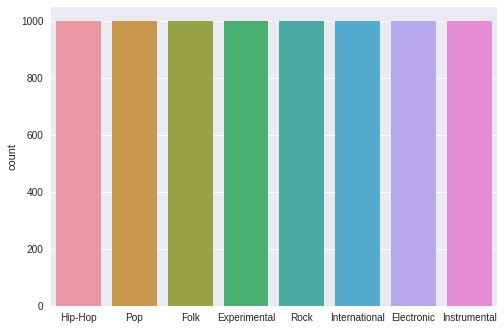

In [0]:
sns.countplot(np.array(genre_list))

In [0]:
for i in range(X.shape[1]):
  plt.figure()
  sns.distplot(X[:,i])
  plt.title(data.columns[i])

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [0]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5357, 167), (2640, 167), (5357, 8), (2640, 8))

Conv > Normalization > Activation > Dropout > Pooling

In [0]:
def get_model(x_shape, y_shape):
  model = models.Sequential()
  
  model.add(layers.Dense(128, input_shape=(x_shape,), kernel_regularizer=regularizers.l2(0.3)))
  model.add(layers.BatchNormalization())
  model.add(layers.Activation('relu'))
  model.add(layers.Dropout(0.5))
  
  model.add(layers.Dense(y_shape, activation='softmax'))
  
  model.compile(loss=losses.categorical_crossentropy, optimizer=optimizers.Adam(lr=0.001), metrics=['accuracy'])
  return model


In [0]:
cbs = [callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=50, mode='auto', restore_best_weights=True)]

In [0]:
model = get_model(X_train.shape[1], y_train.shape[1])

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_118 (Dense)            (None, 128)               21504     
_________________________________________________________________
batch_normalization_95 (Batc (None, 128)               512       
_________________________________________________________________
activation_95 (Activation)   (None, 128)               0         
_________________________________________________________________
dropout_89 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_119 (Dense)            (None, 8)                 1032      
Total params: 23,048
Trainable params: 22,792
Non-trainable params: 256
_________________________________________________________________


### Run

In [0]:
model = get_model(X_train.shape[1], y_train.shape[1])
history = model.fit(X_train,
                    y_train,
                    epochs=400,
                    batch_size=1024,
                    validation_data=(X_test, y_test),
                    callbacks=cbs)

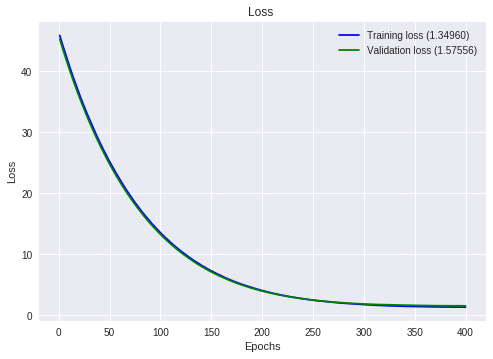

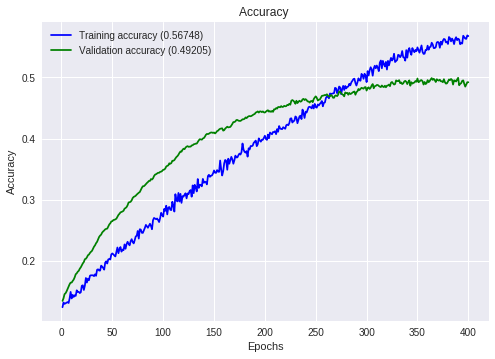

In [0]:
plot_history(history)

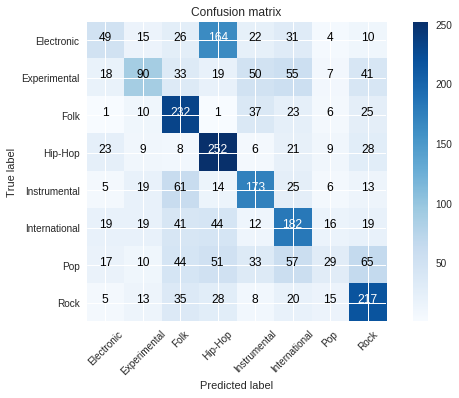

In [0]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1) 
y_test_classes = np.argmax(y_test, axis=1) 
confusion_mtx = confusion_matrix(y_test_classes, y_pred_classes)
plot_confusion_matrix(confusion_mtx, classes=encoder.classes_)

### Feature importance

In [0]:
my_model = KerasRegressor(build_fn=get_model,
  x_shape=X_train.shape[1], y_shape=y_train.shape[1],
  epochs=2000, batch_size=1024, validation_data=(X_test, y_test), callbacks=cbs)    
hist = my_model.fit(X_train, y_train)
perm = PermutationImportance(my_model, random_state=42).fit(X_train, y_train)

In [0]:
eli5.show_weights(perm, feature_names=data.columns[:-1].tolist(), top=None)

Weight,Feature
0.0609 ± 0.0035,mel1
0.0602 ± 0.0057,mfcc3
0.0484 ± 0.0044,mfcc1
0.0435 ± 0.0057,mel2
0.0394 ± 0.0065,rmse
0.0363 ± 0.0045,mfcc0
0.0342 ± 0.0033,spec_bw
0.0327 ± 0.0033,mfcc7
0.0327 ± 0.0035,spec_contrast1
0.0279 ± 0.0024,mfcc6


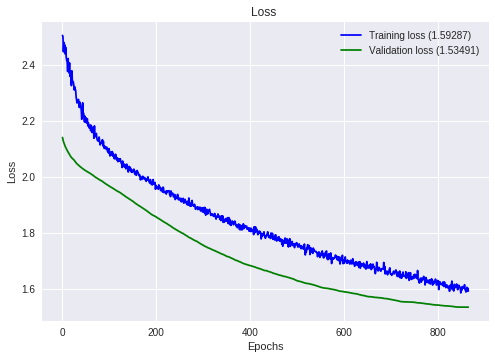

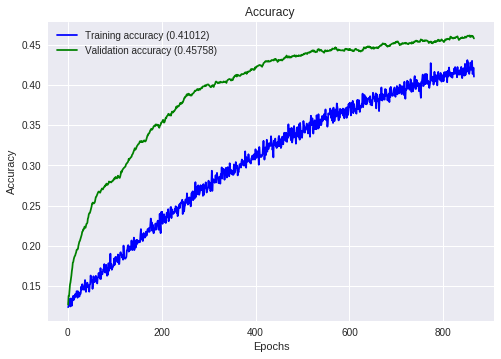

In [0]:
plot_history(hist)

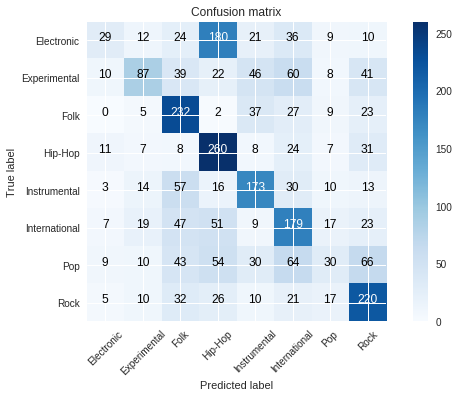

In [0]:
y_pred = my_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1) 
y_test_classes = np.argmax(y_test, axis=1) 
confusion_mtx = confusion_matrix(y_test_classes, y_pred_classes)
plot_confusion_matrix(confusion_mtx, classes=encoder.classes_)

# Neural networks using custom

### Prepare data

In [0]:
# fma_data_file fma_windowed_data_file
data = pd.read_csv(fma_windowed_data_file)
data.head()

,filename,start,end,mfcc0,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,...,mel125,mel126,mel127,tonnetz0,tonnetz1,tonnetz2,tonnetz3,tonnetz4,tonnetz5,label
0,2,0,71936,-50.708680,47.050746,-11.920939,4.257627,-0.979859,9.854892,-5.404521,...,0.073454,0.014657,0.000925,0.006629,0.033068,0.034992,0.114704,0.004393,0.025396,Hip-Hop
1,2,35968,107904,-47.928056,48.484360,-10.096974,10.016634,-0.224858,10.008623,-7.498311,...,0.059582,0.014064,0.000906,0.005707,0.033435,0.037684,0.134660,0.005239,0.026874,Hip-Hop
2,2,71936,143872,-47.806087,52.152929,-6.258267,10.950935,-4.035142,10.252514,-6.774817,...,0.050227,0.012523,0.000887,0.006481,0.038702,0.033055,0.146563,0.007609,0.029359,Hip-Hop
3,2,107904,179840,-41.219064,54.099599,-6.256125,10.966060,-3.446172,9.483042,-5.100740,...,0.072263,0.015358,0.000995,0.007014,0.032434,0.032143,0.115521,0.004110,0.026238,Hip-Hop
4,2,143872,215808,-22.250247,52.794211,-10.176864,16.147555,-0.875264,6.962842,-4.095985,...,0.094527,0.016908,0.000991,0.002686,0.032346,0.038654,0.118025,0.001145,0.025962,Hip-Hop


In [0]:
data.shape

(71938, 171)

In [0]:
filenames = skl.utils.shuffle(np.unique(data['filename']), random_state=42)
filenames[:5]

array([115812,  59724,  82931, 121740, 143057])

In [0]:
data['filename'] = pd.Categorical(data['filename'], filenames)
data = data.sort_values('filename')
data.head()

,filename,start,end,mfcc0,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,...,mel125,mel126,mel127,tonnetz0,tonnetz1,tonnetz2,tonnetz3,tonnetz4,tonnetz5,label
49378,115812,107904,179840,-15.516912,70.176002,15.054555,13.349528,6.355750,6.413113,-3.802365,...,0.234595,0.046254,0.003031,0.014759,0.026246,0.008069,0.014134,0.007363,-0.003231,Electronic
49376,115812,35968,107904,-24.476266,67.406451,9.800350,11.721465,3.066293,5.301534,-0.153366,...,0.168462,0.044509,0.002010,0.031437,0.015653,-0.051240,-0.105498,-0.025451,-0.002975,Electronic
49383,115812,287744,359680,-15.094479,76.538014,13.945361,16.333100,4.858037,7.351178,-2.734482,...,0.233389,0.042321,0.002201,0.018424,0.024695,-0.045226,-0.028680,-0.009238,-0.002386,Electronic
49379,115812,143872,215808,-13.688662,72.257810,12.927577,15.185375,4.716276,6.907298,-4.564192,...,0.191798,0.041197,0.002553,0.022475,0.026725,0.010622,0.017473,-0.000327,-0.000947,Electronic
49380,115812,179840,251776,-14.606361,74.741891,12.105236,16.884369,4.169228,6.915768,-3.770980,...,0.199517,0.035423,0.001866,0.018504,0.027484,-0.044418,0.053742,-0.010135,0.005143,Electronic


In [0]:
split_index = int(len(data) * 0.66) + 1
for i in range(split_index, len(data)):
  if data['filename'][split_index] != data['filename'][split_index - 1]:
    break
  split_index += 1

data.iloc[split_index], data.iloc[split_index - 1], split_index, split_index / len(data)

In [0]:
data = data.drop(['filename', 'start', 'end'], axis=1)

In [0]:
# Encoding the Labels
genre_list = data.iloc[:, -1]
encoder = skl.preprocessing.LabelEncoder()
y = encoder.fit_transform(genre_list)
y = utils.to_categorical(y)

In [0]:
scaler = skl.preprocessing.StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype=float))

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



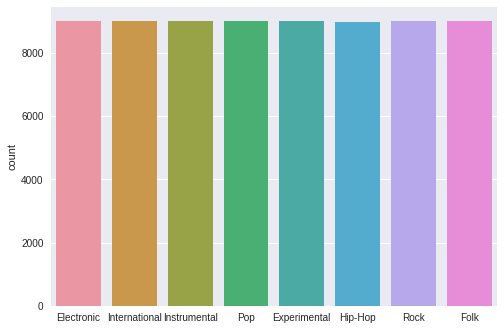

In [0]:
sns.countplot(np.array(genre_list))

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



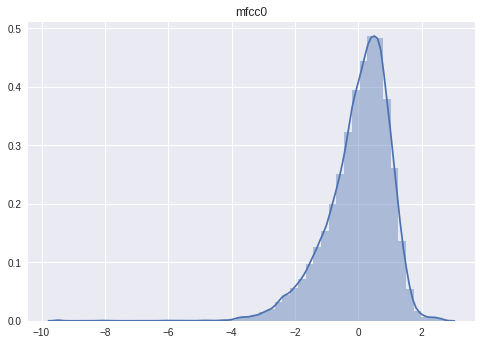

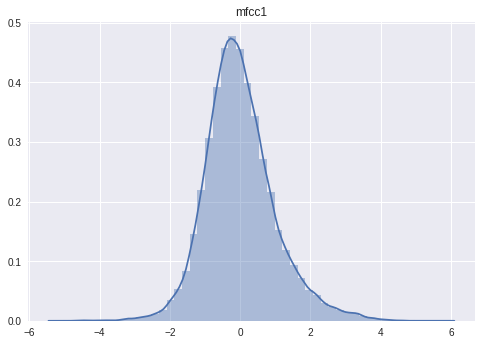

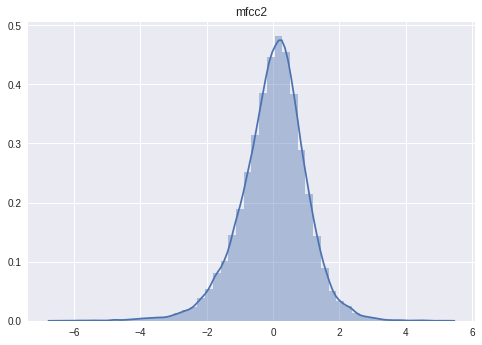

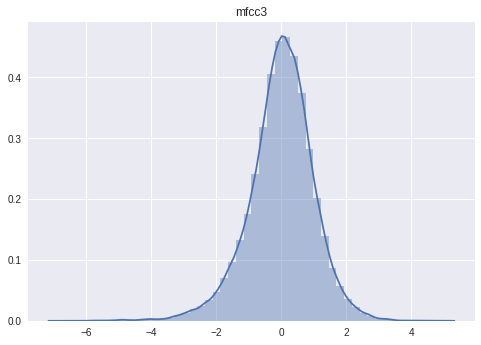

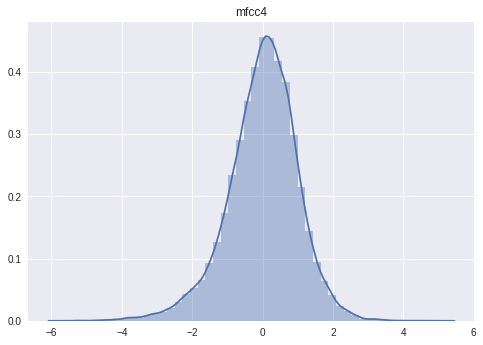

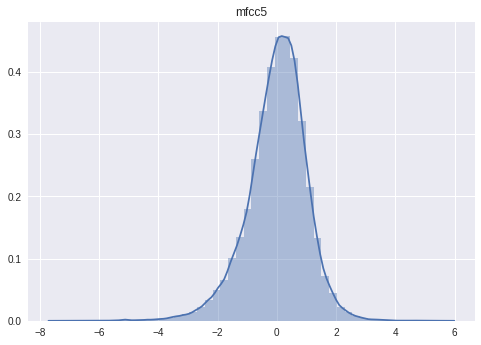

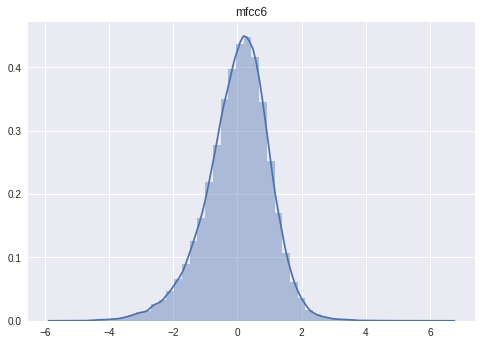

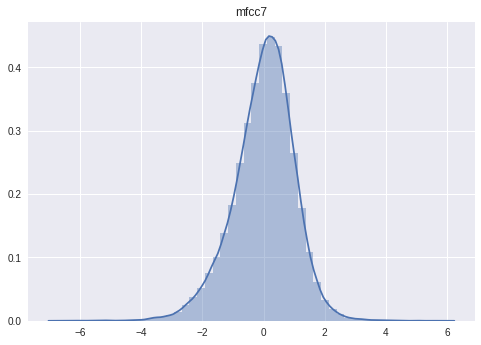

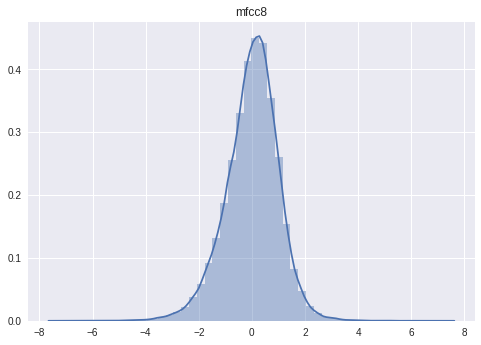

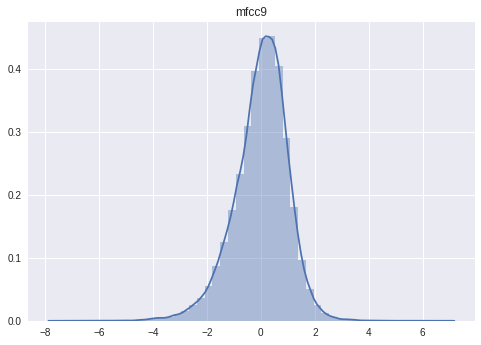

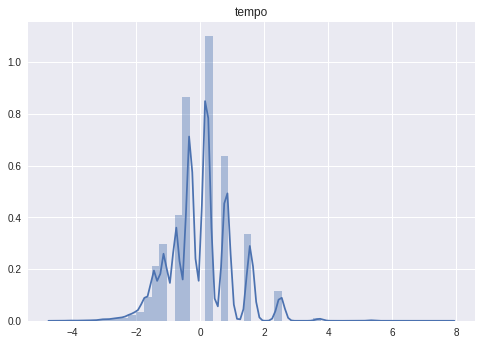

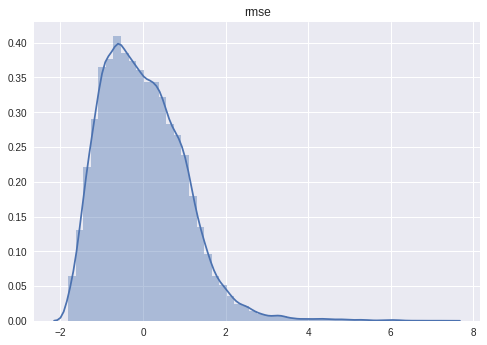

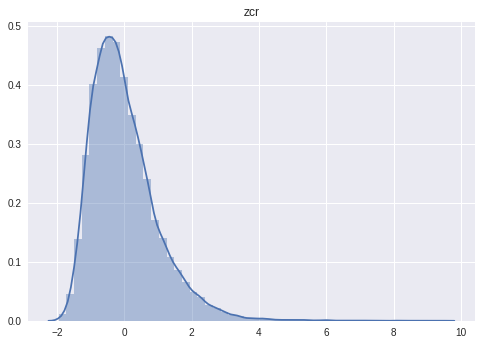

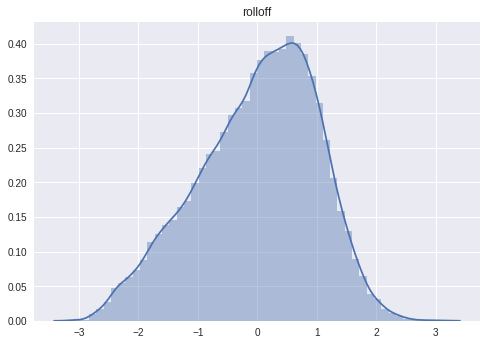

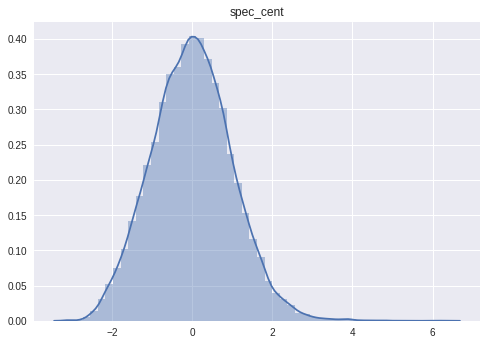

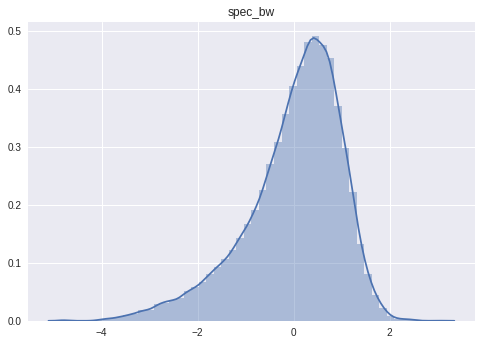

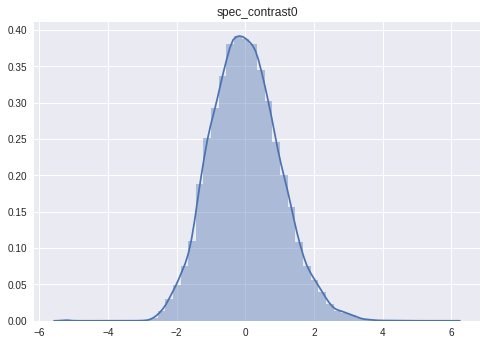

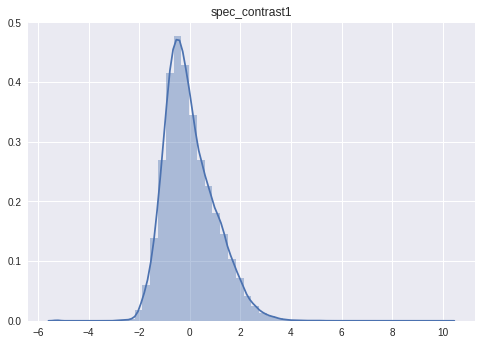

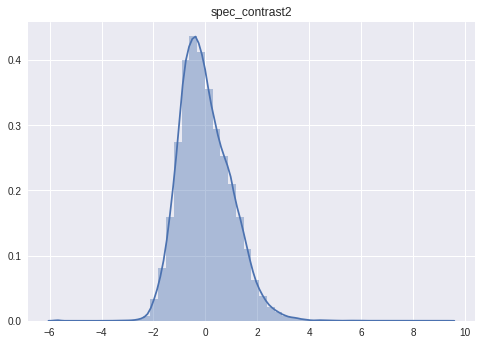

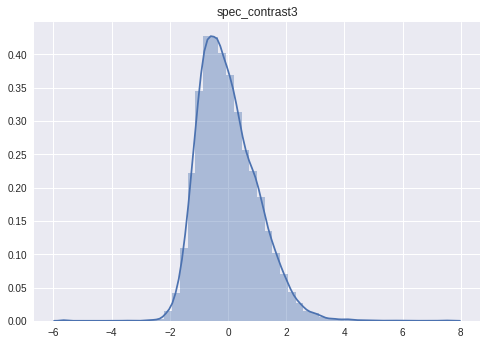

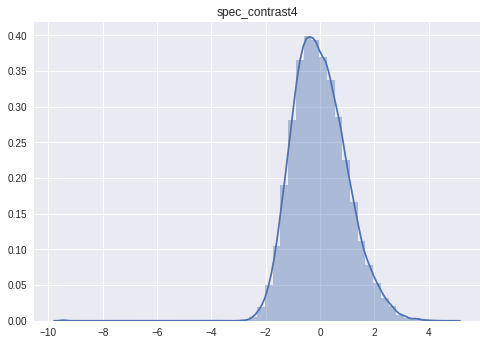

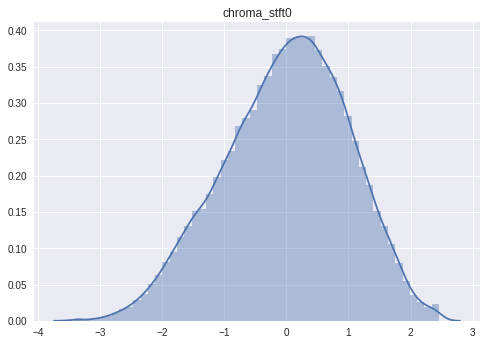

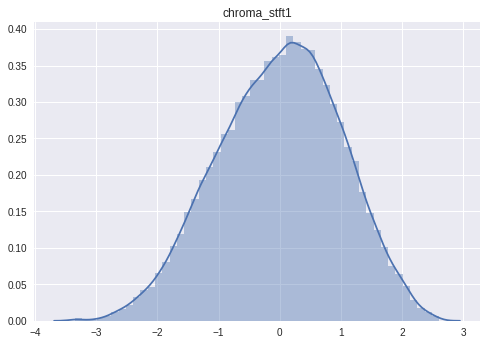

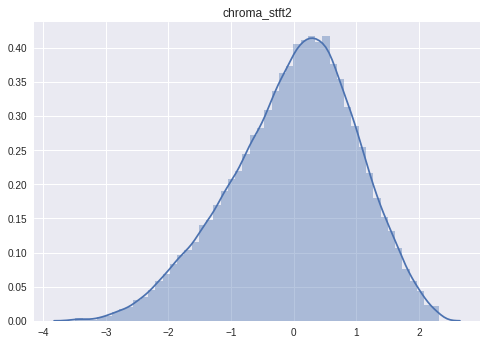

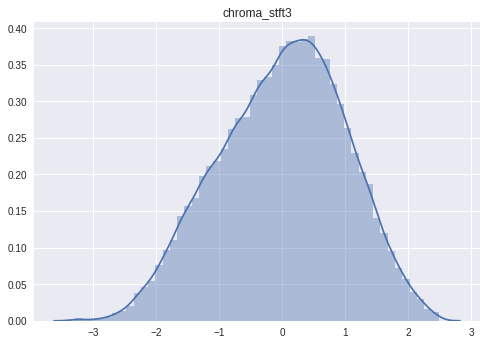

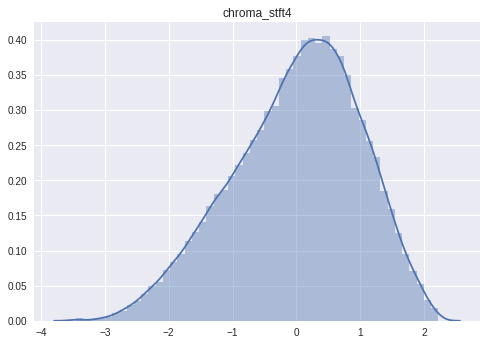

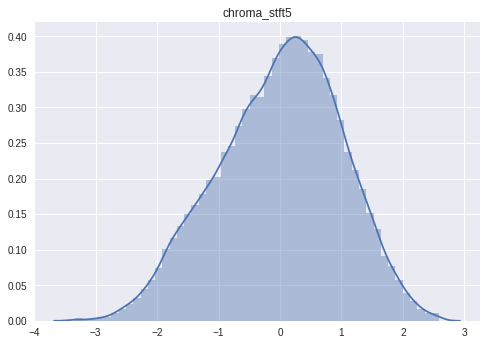

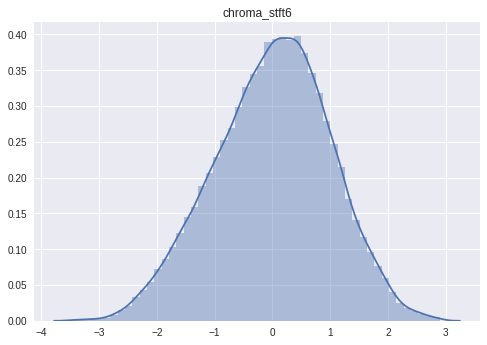

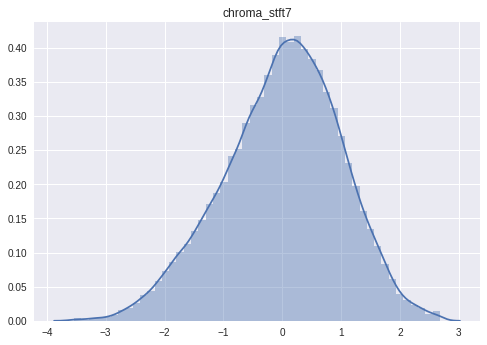

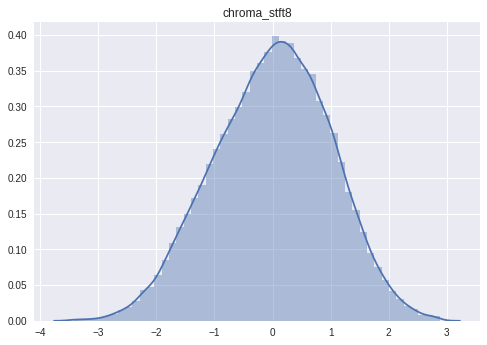

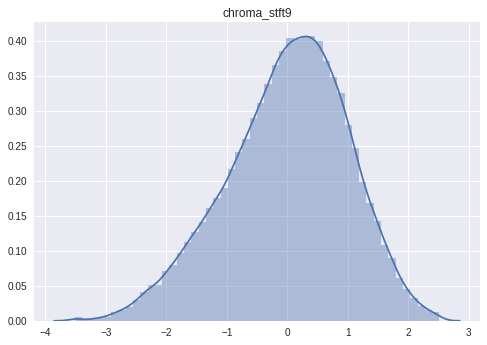

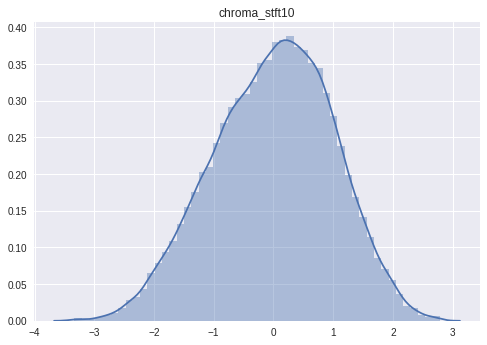

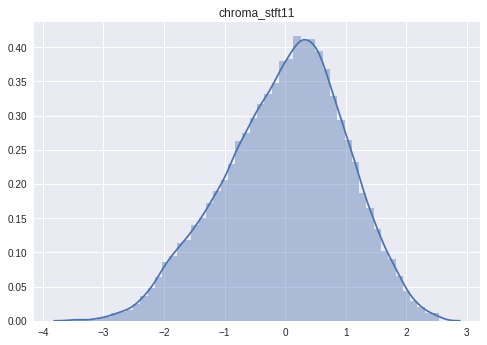

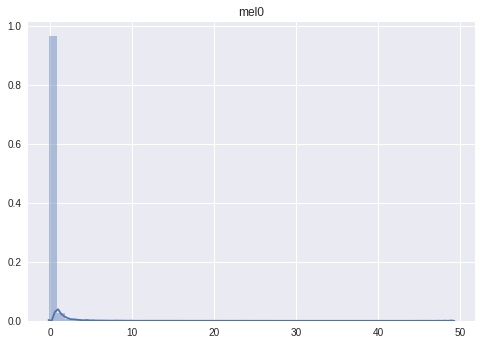

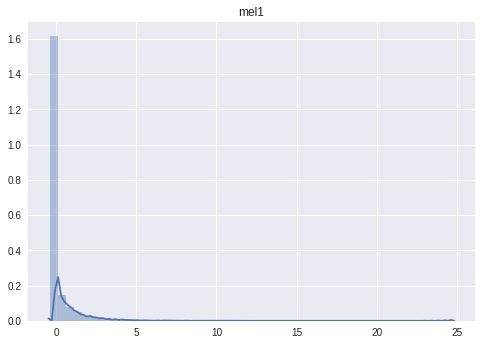

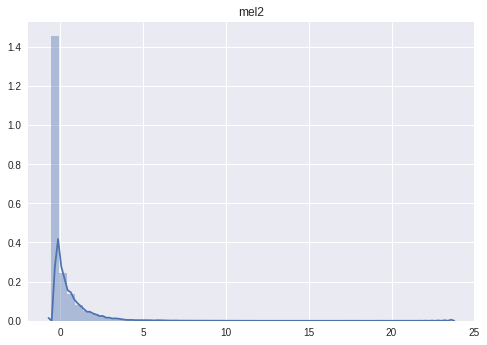

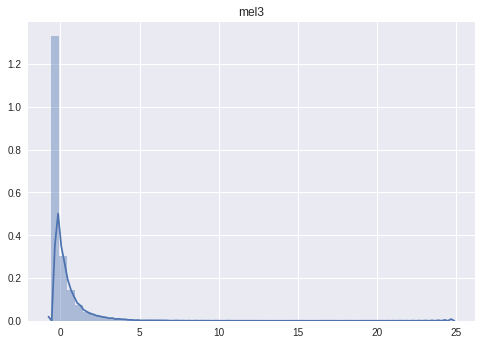

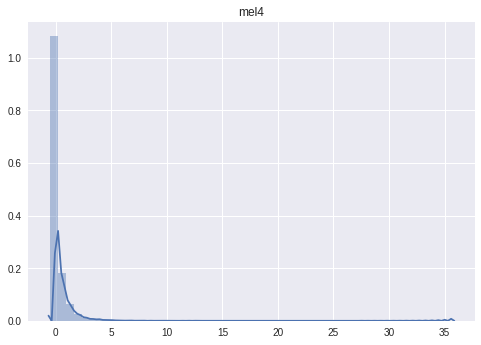

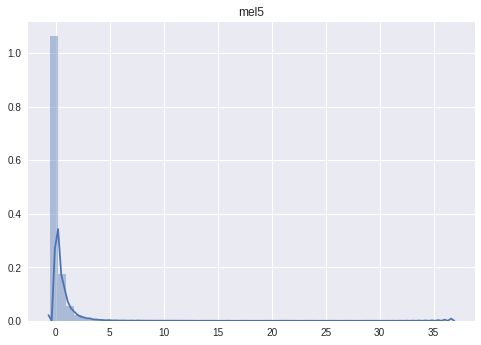

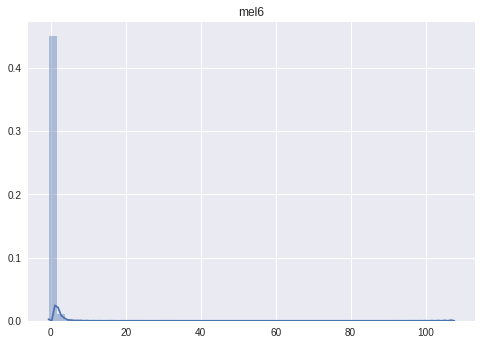

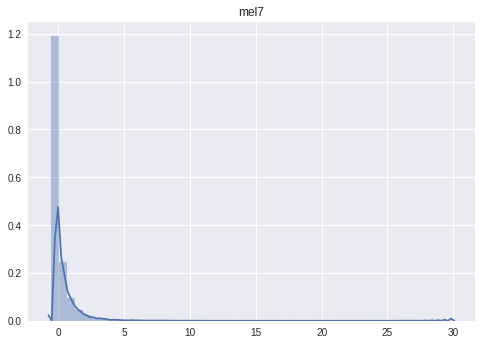

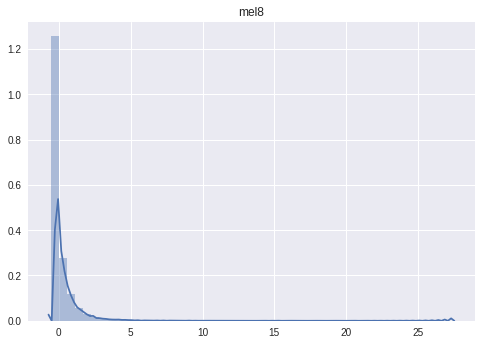

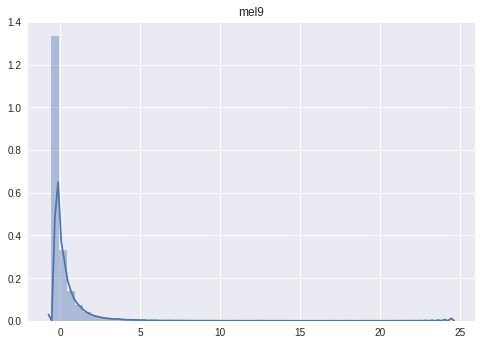

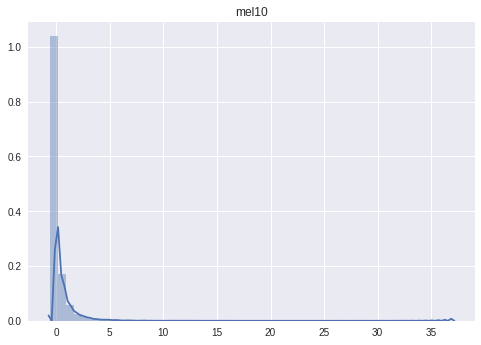

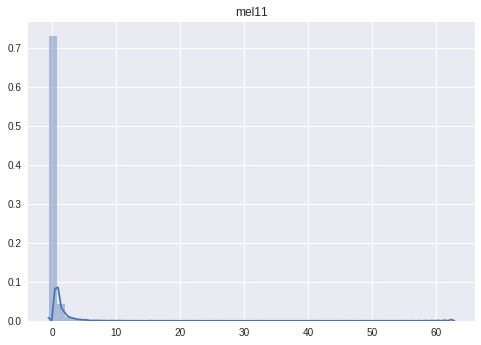

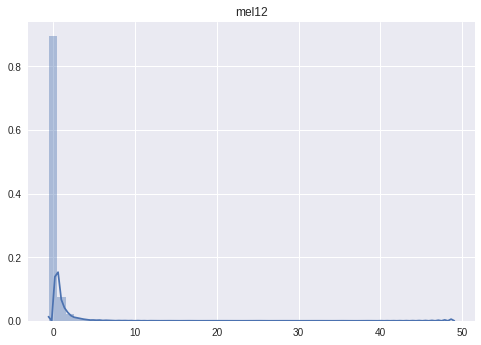

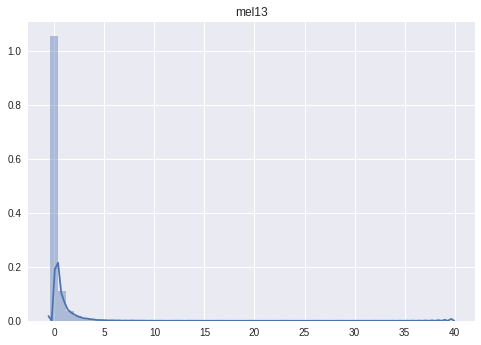

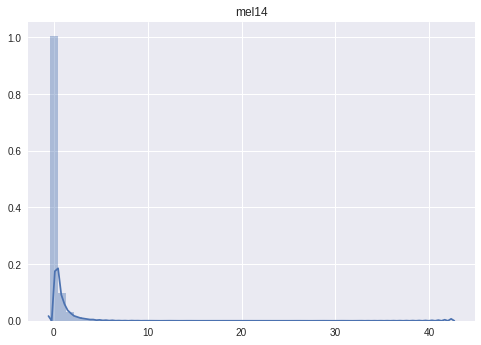

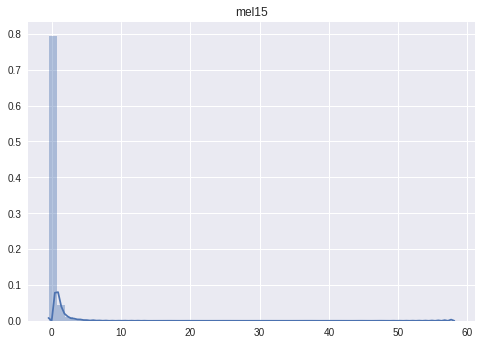

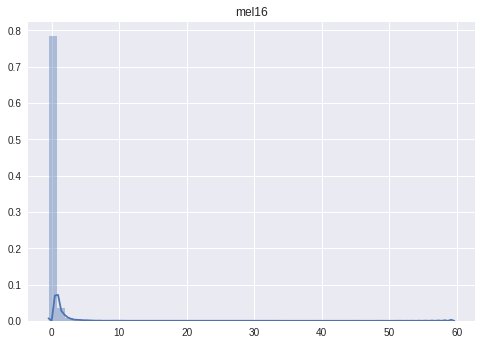

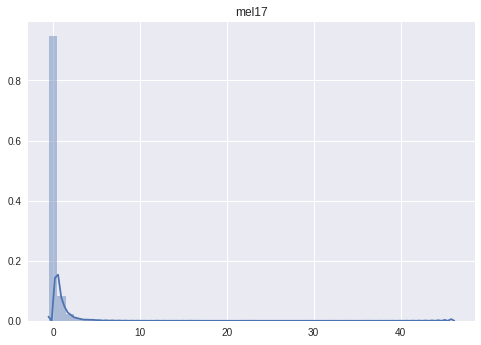

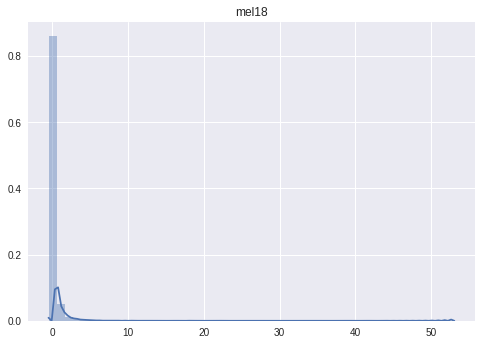

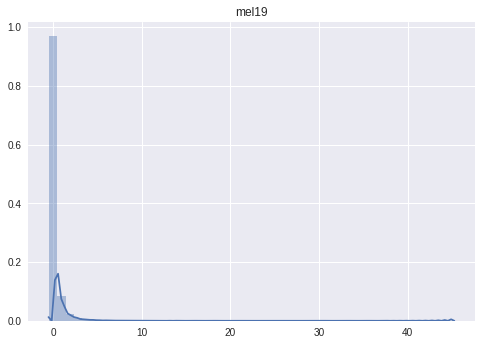

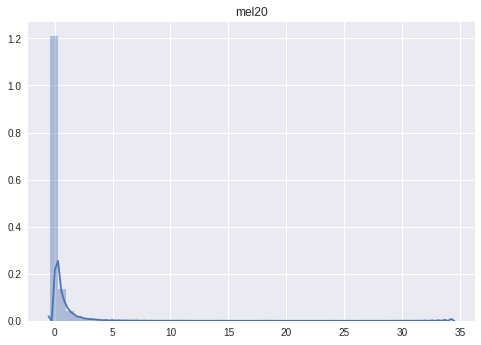

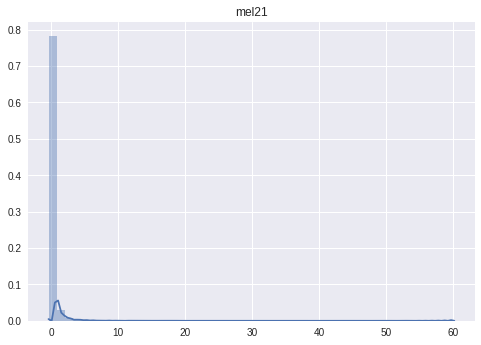

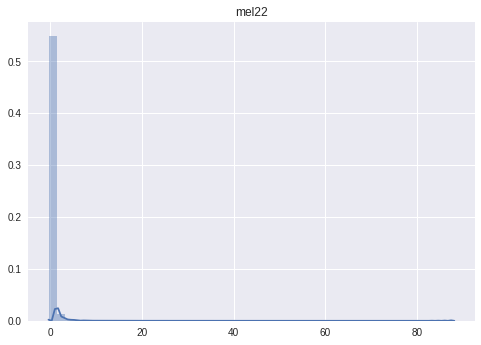

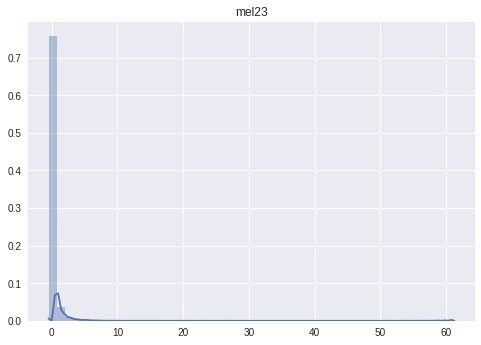

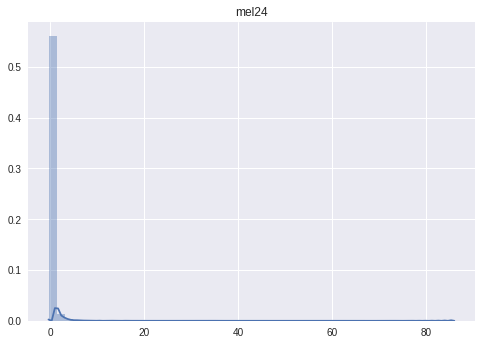

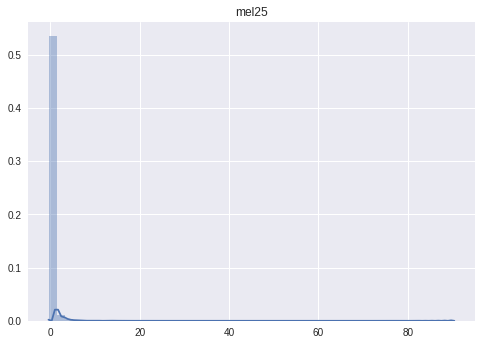

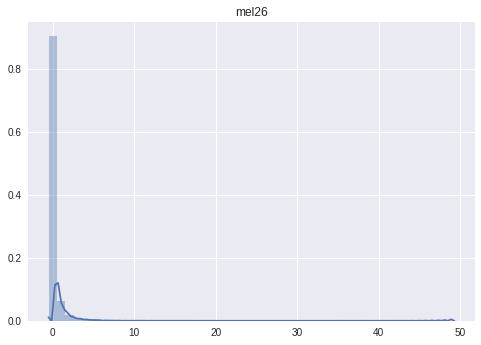

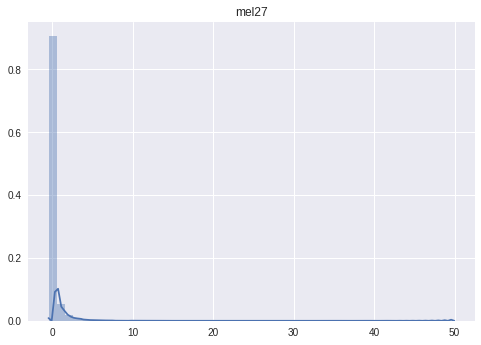

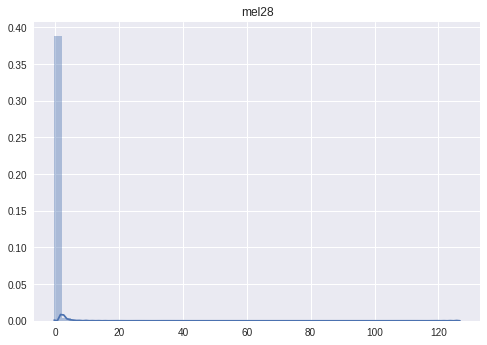

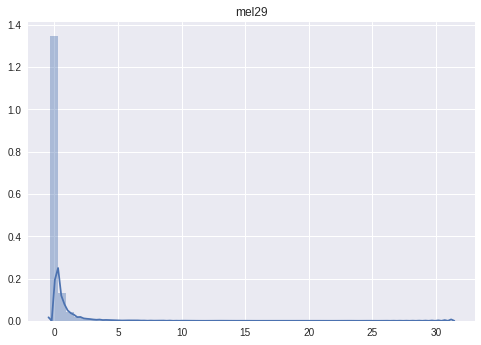

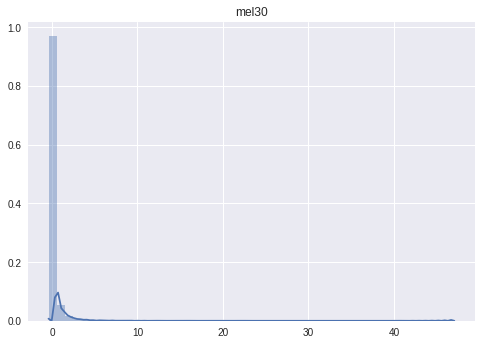

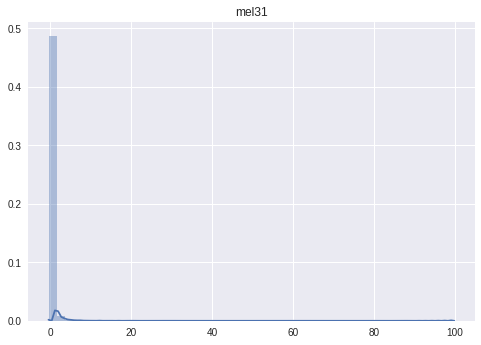

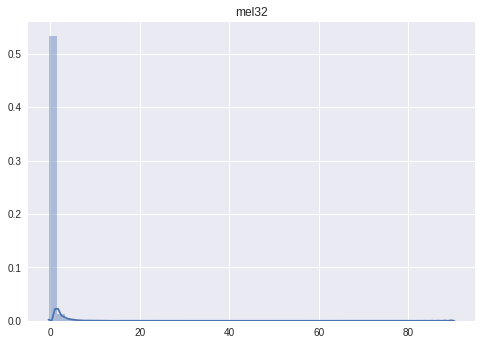

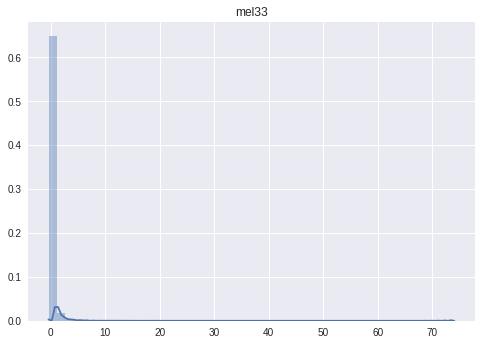

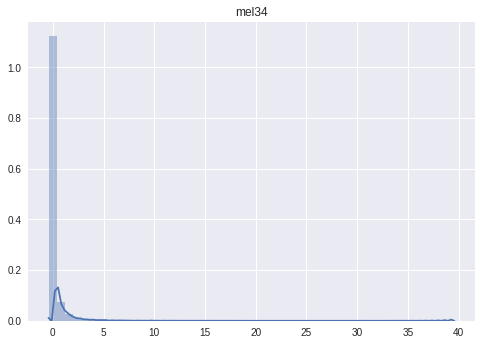

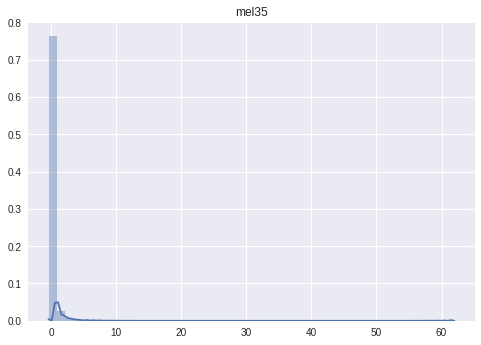

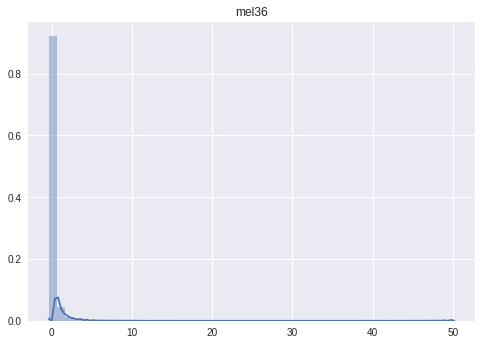

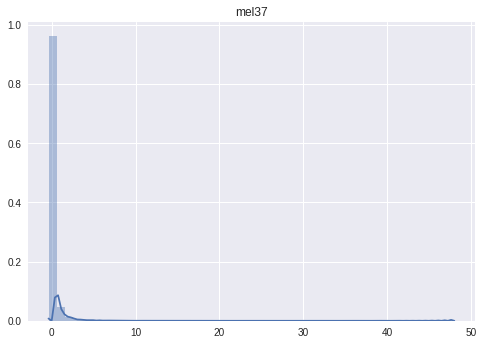

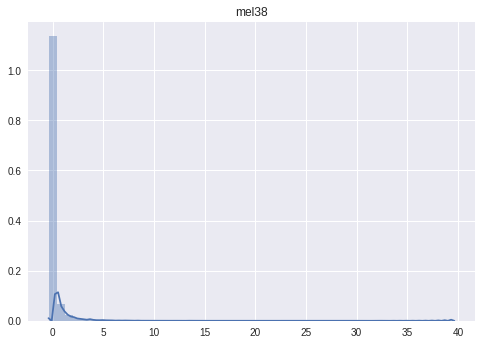

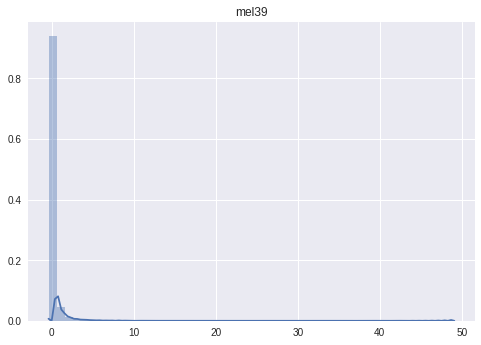

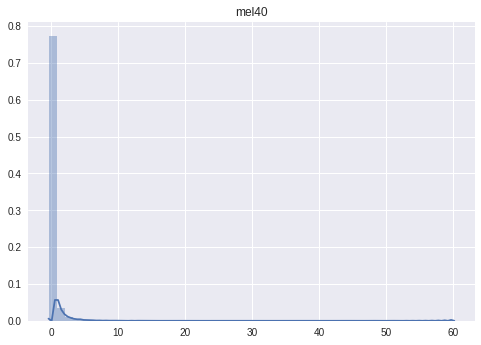

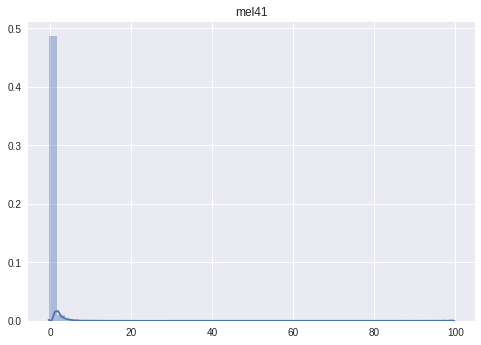

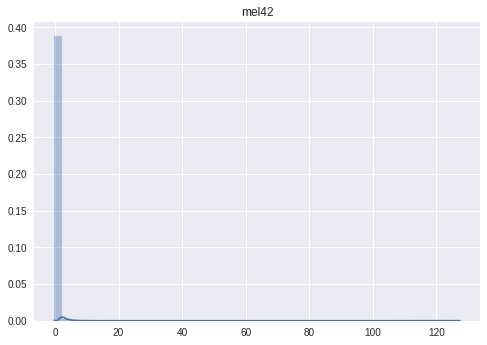

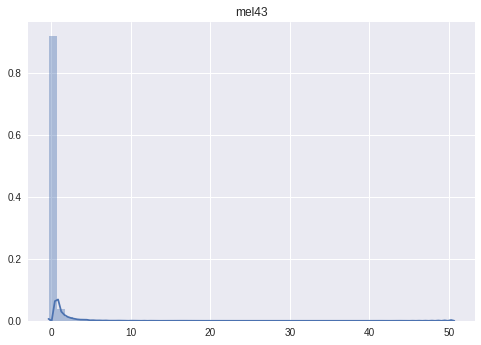

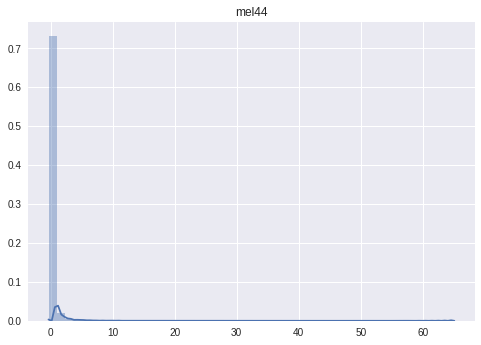

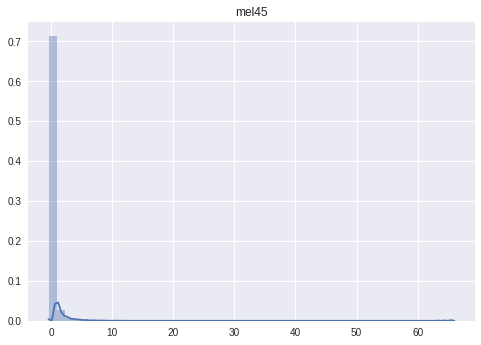

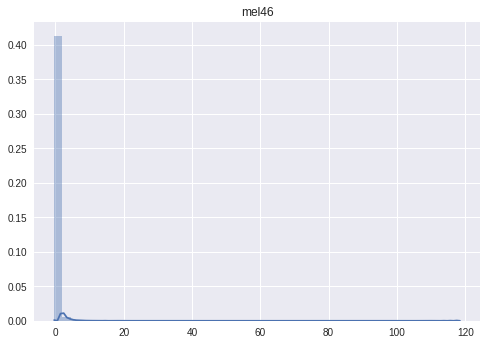

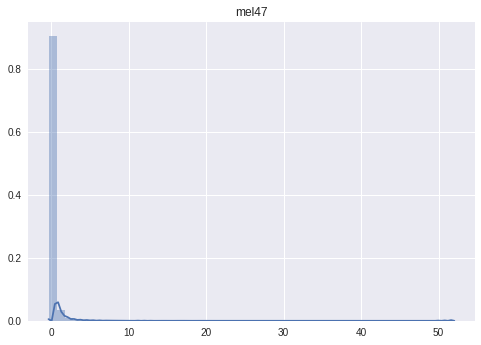

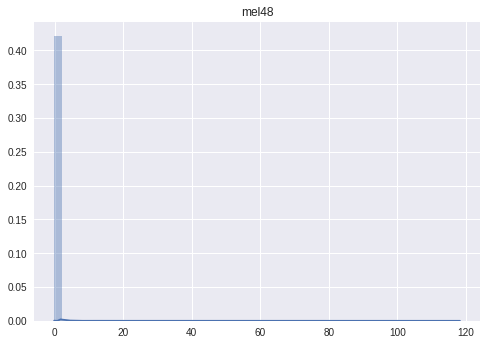

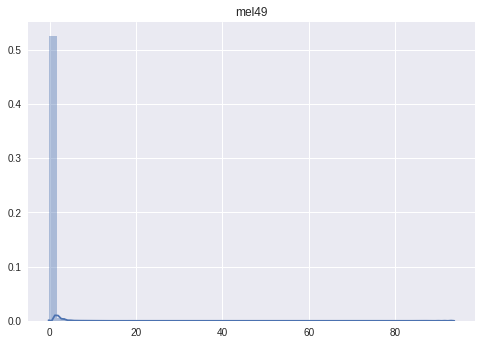

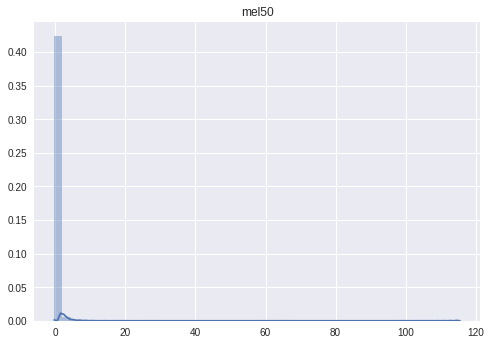

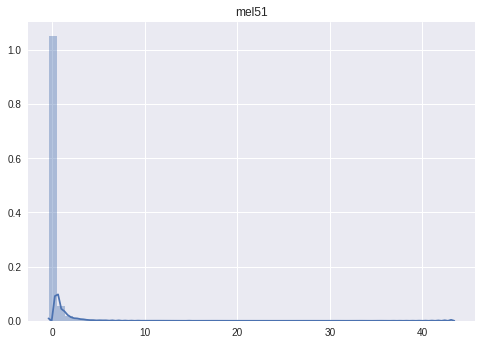

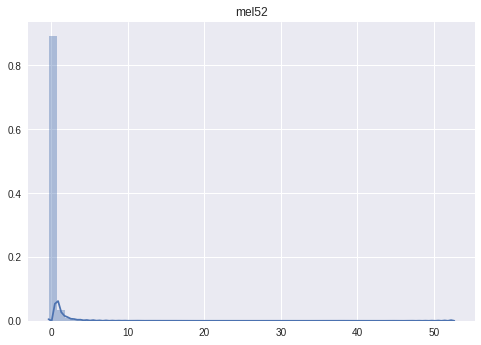

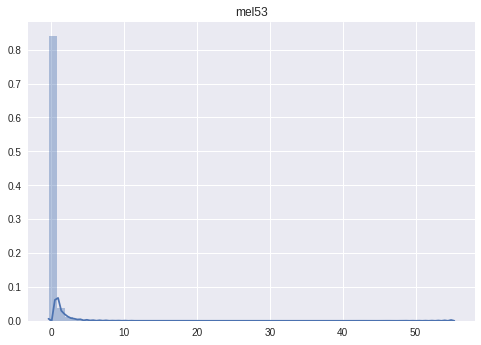

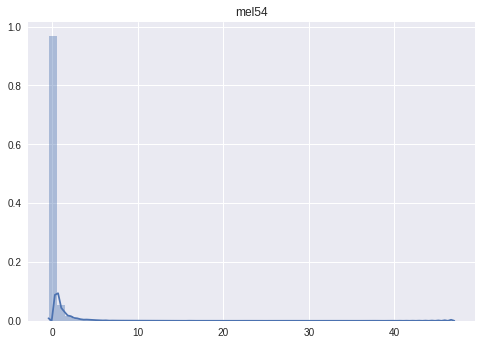

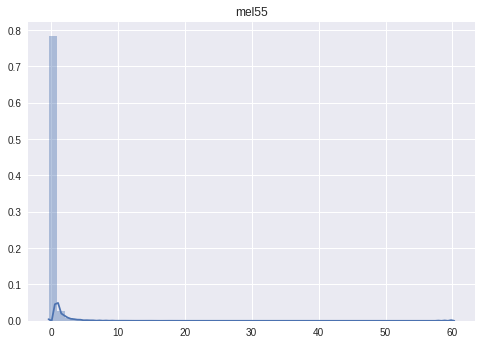

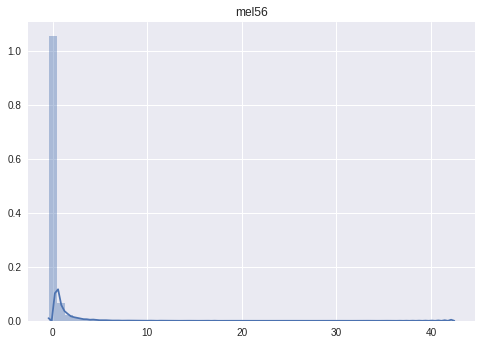

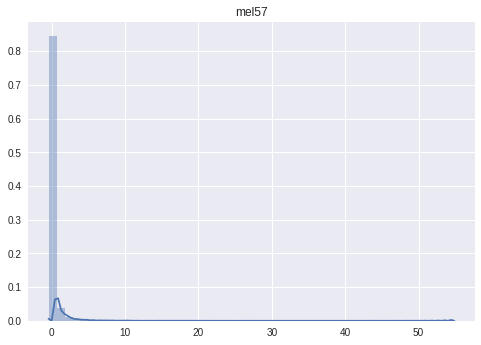

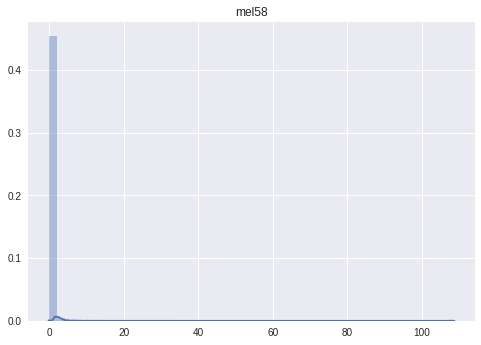

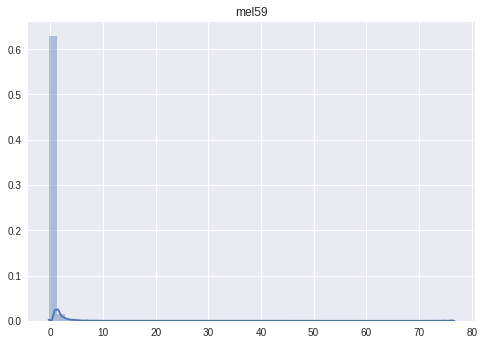

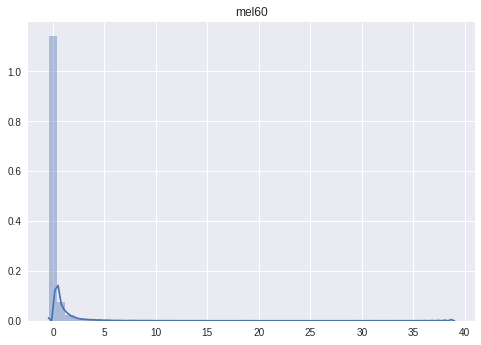

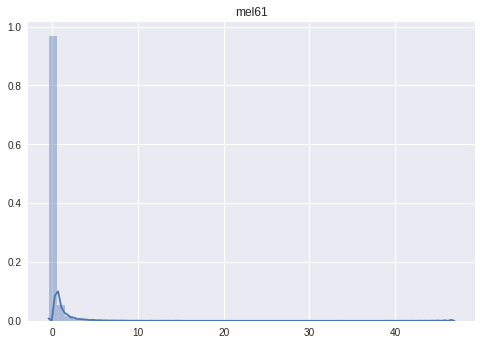

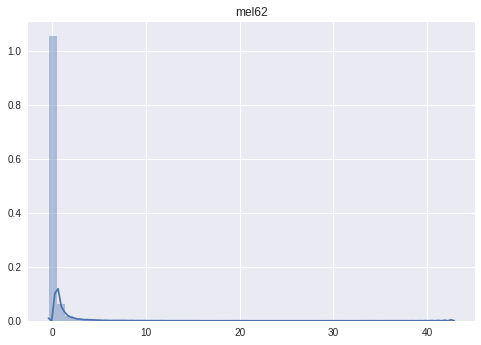

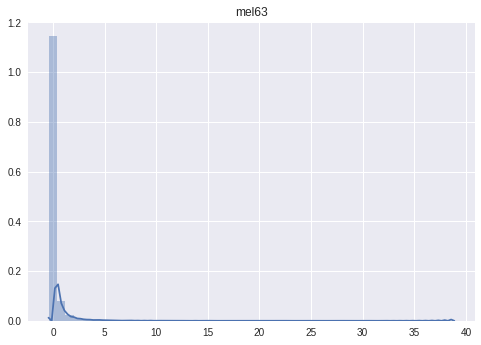

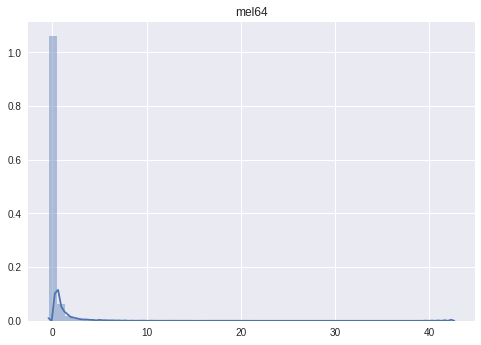

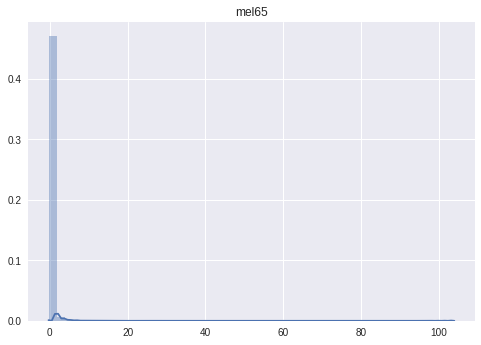

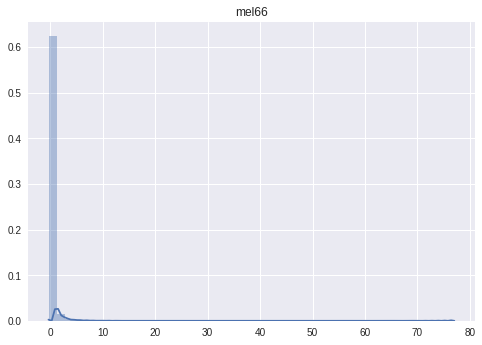

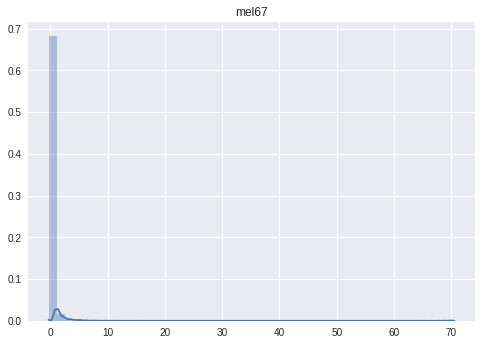

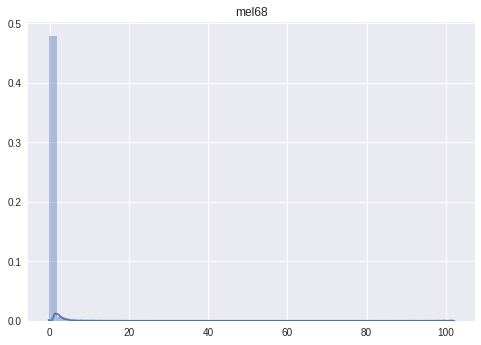

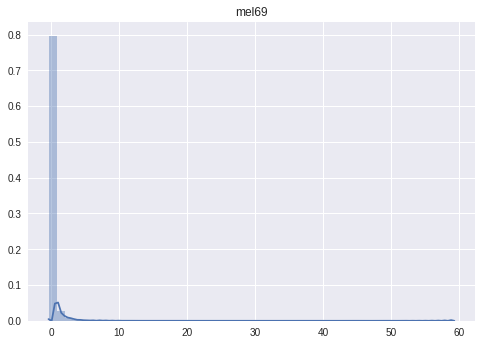

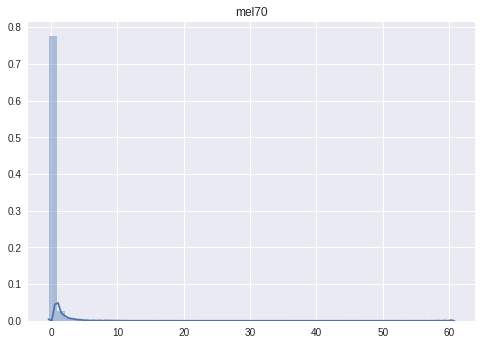

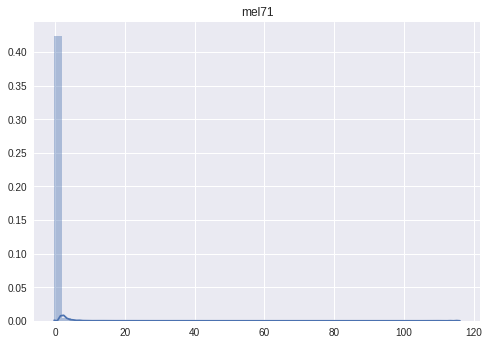

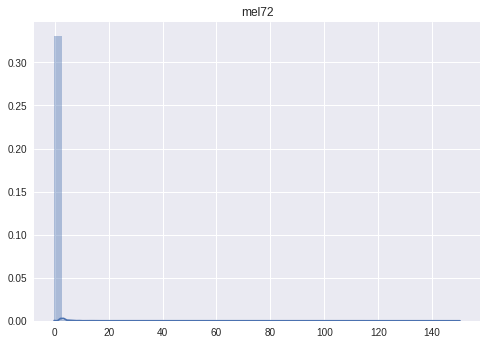

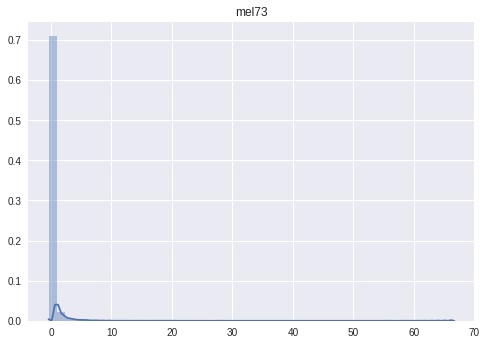

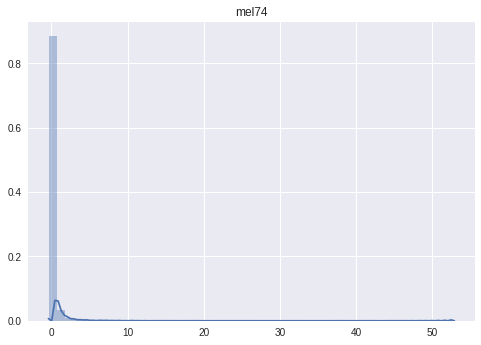

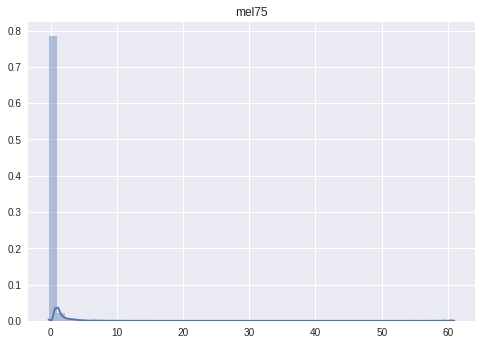

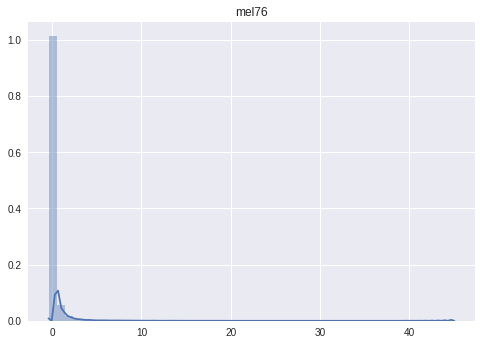

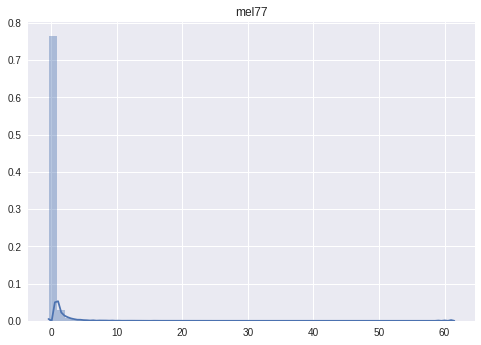

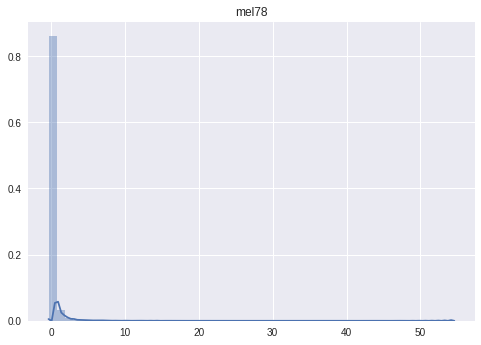

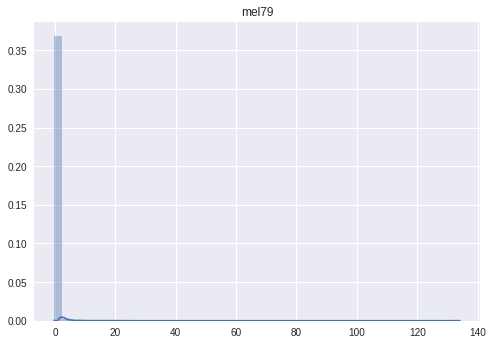

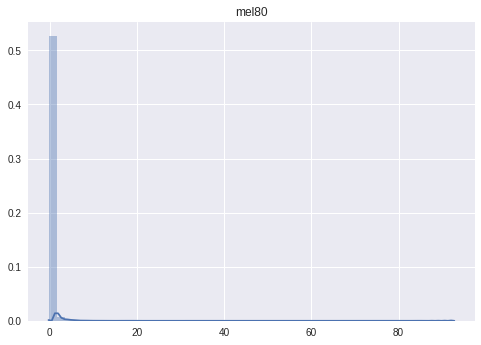

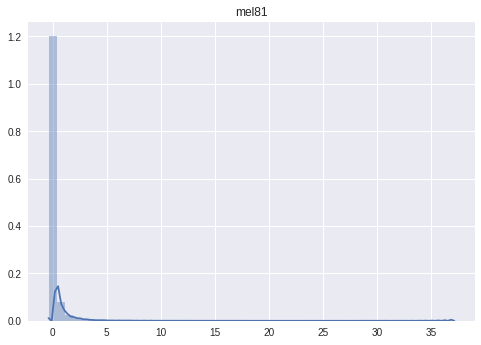

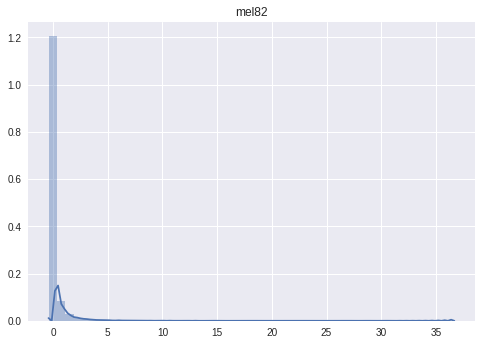

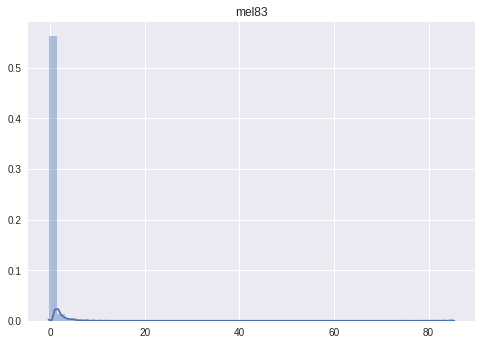

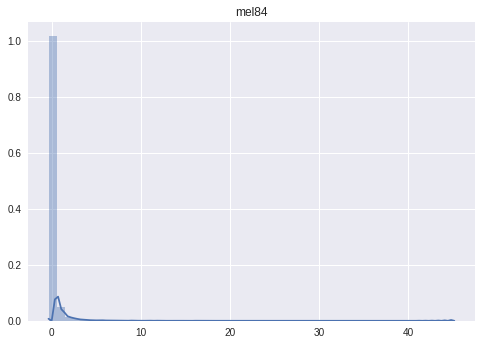

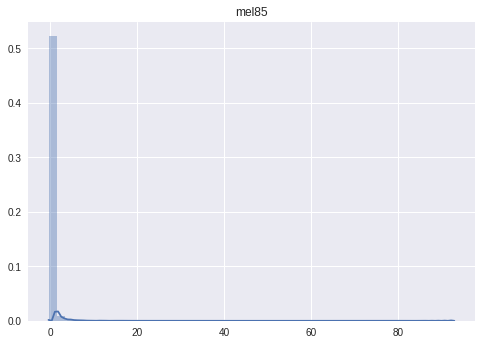

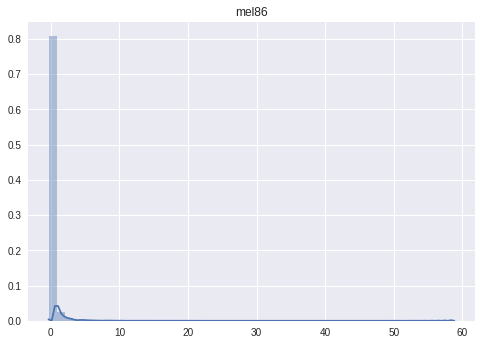

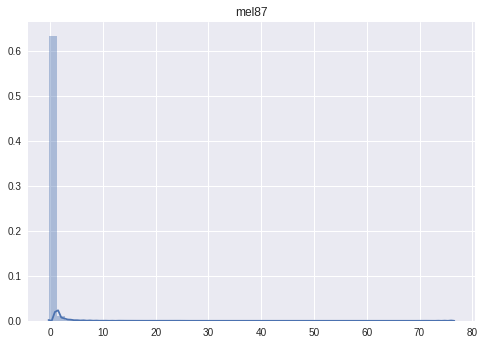

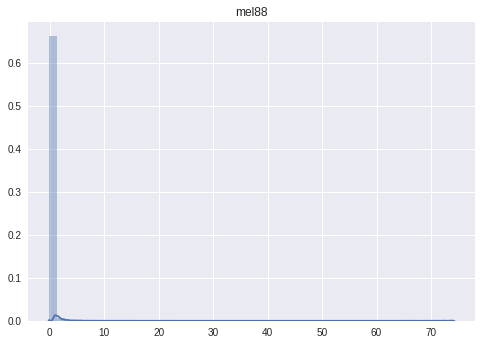

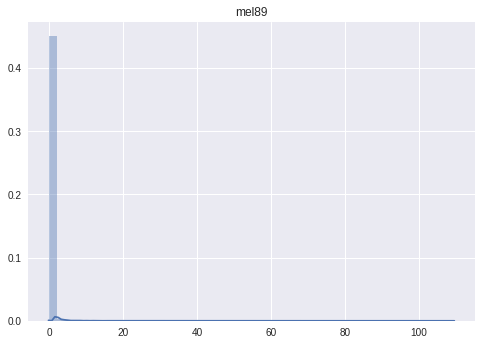

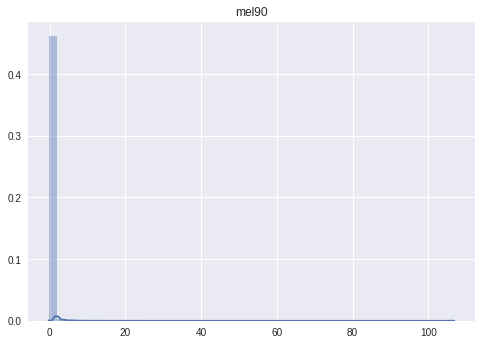

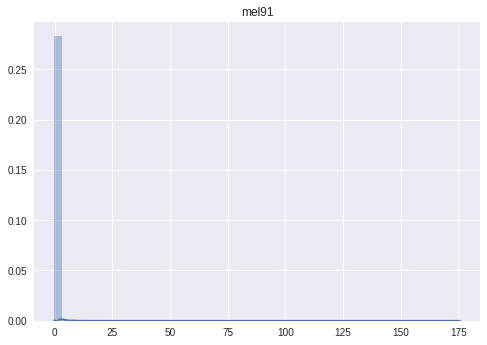

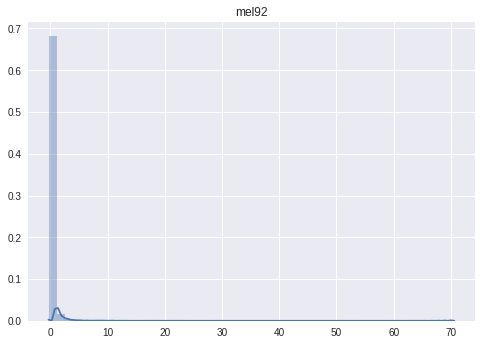

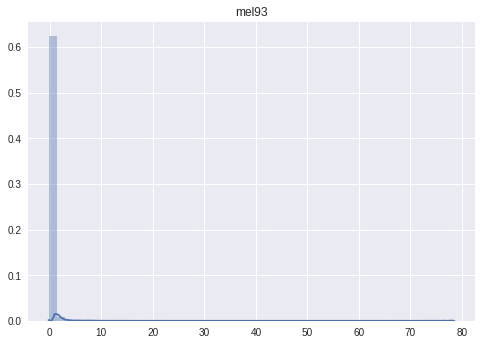

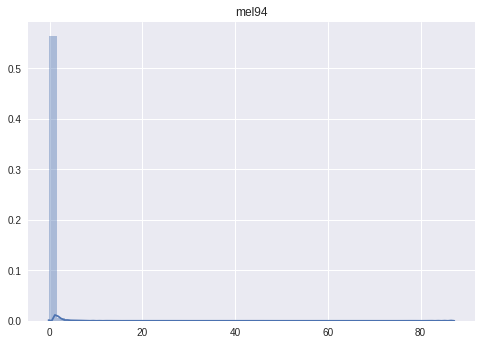

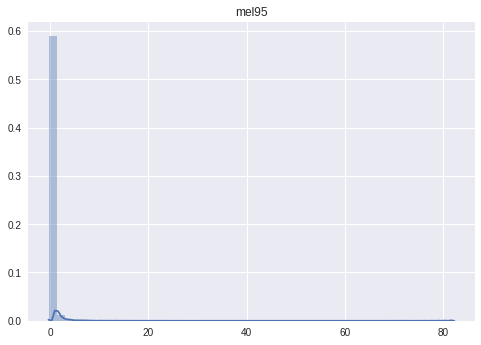

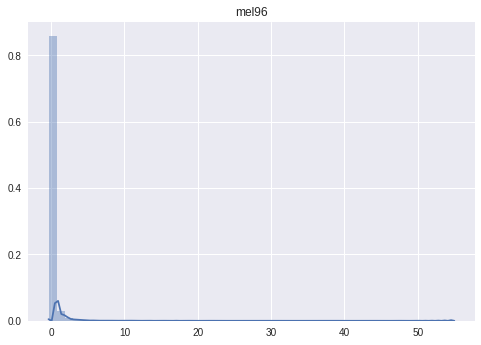

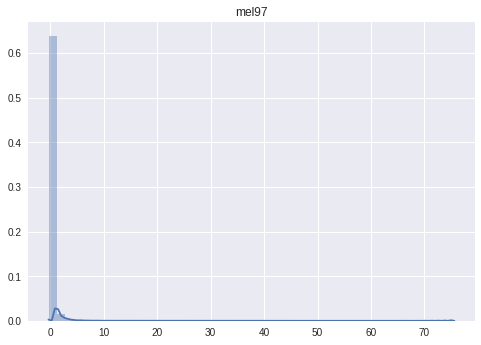

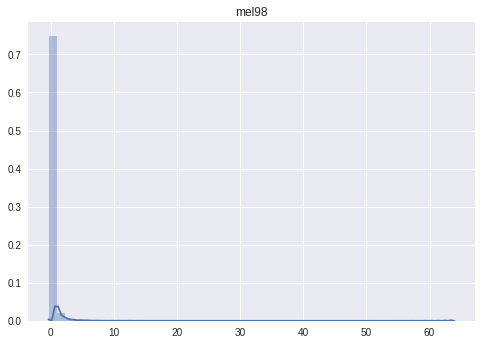

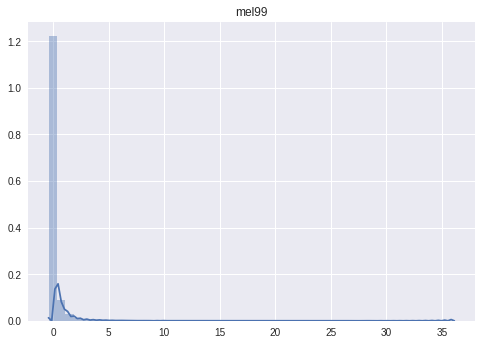

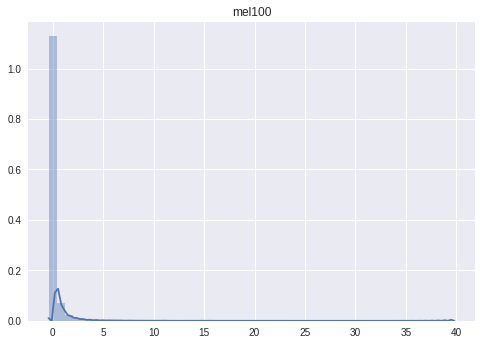

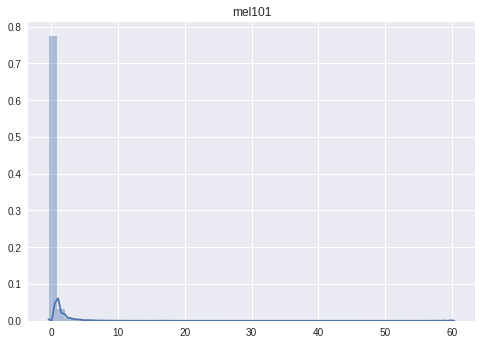

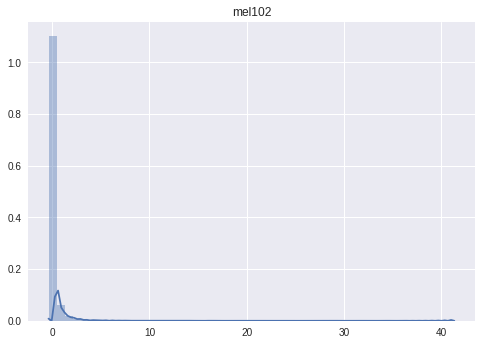

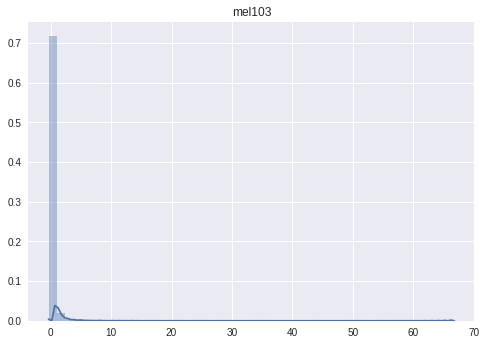

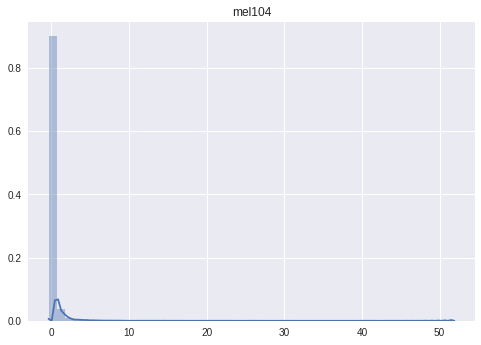

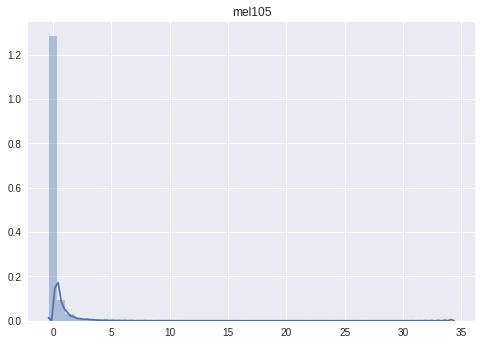

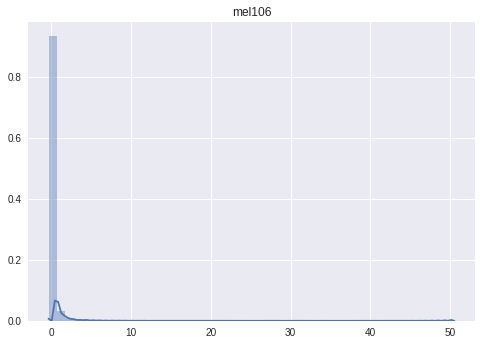

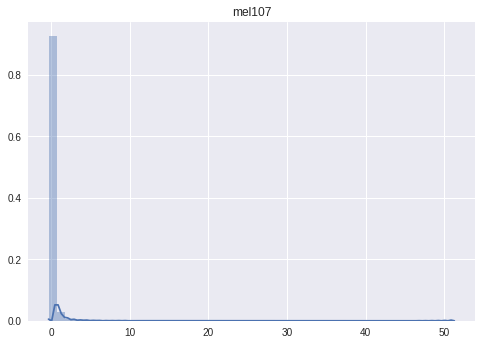

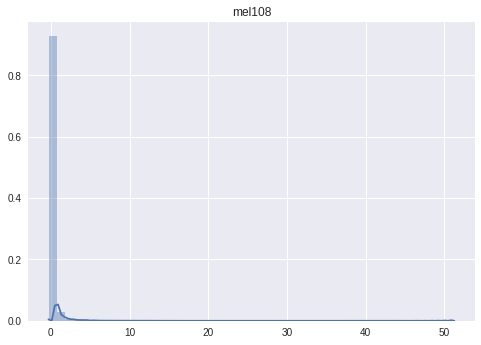

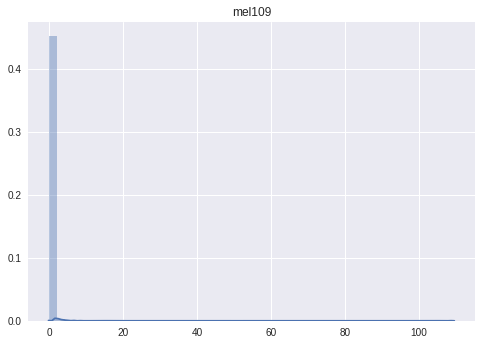

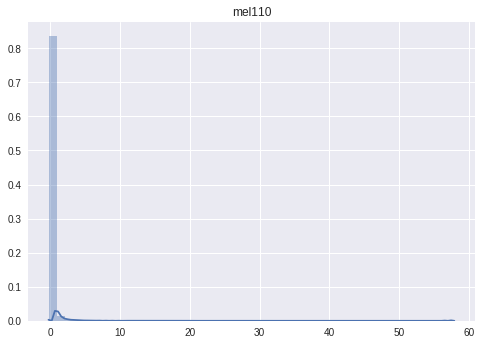

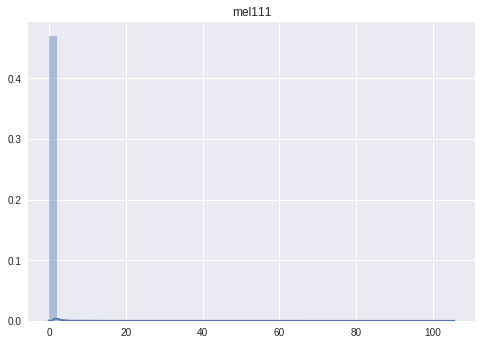

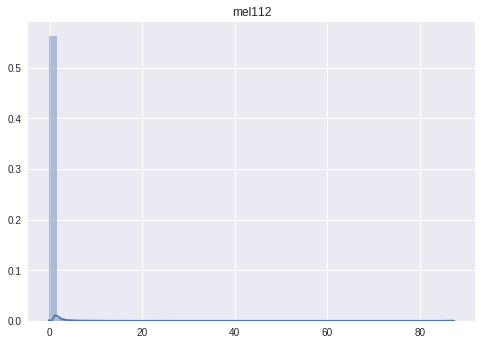

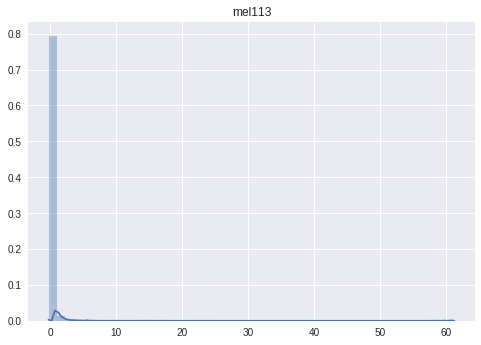

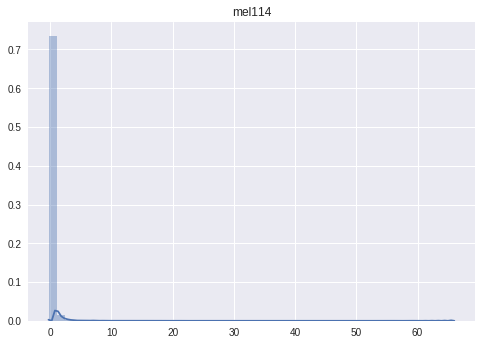

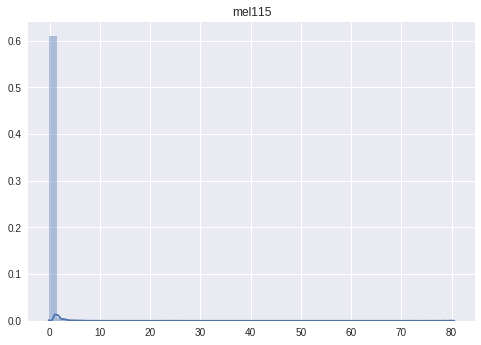

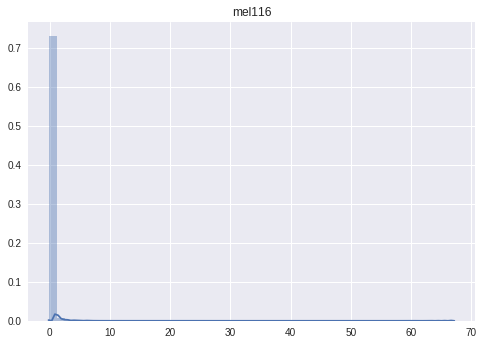

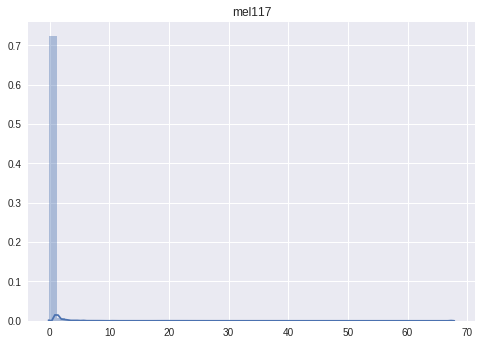

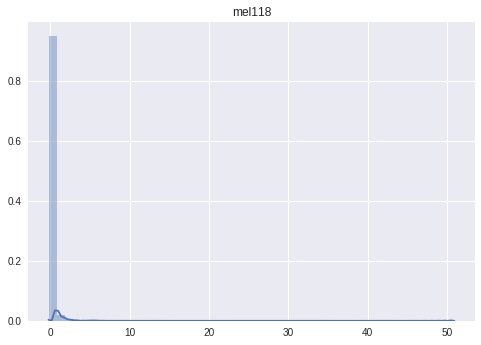

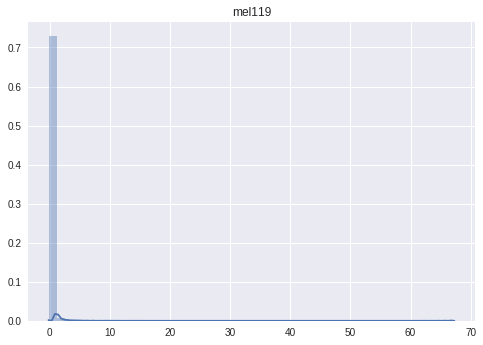

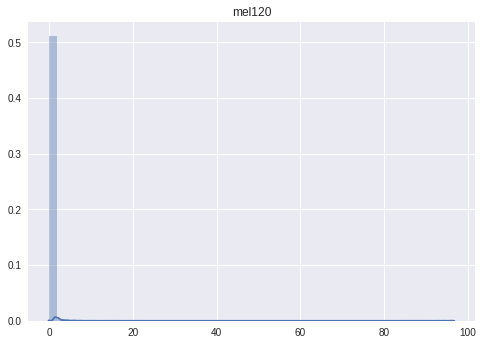

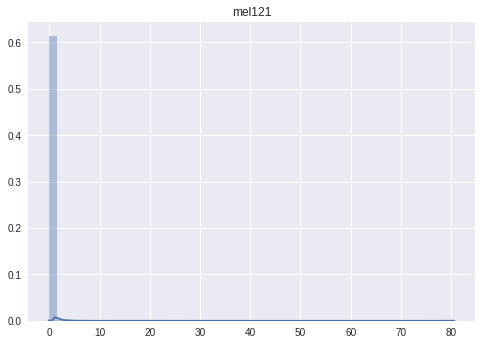

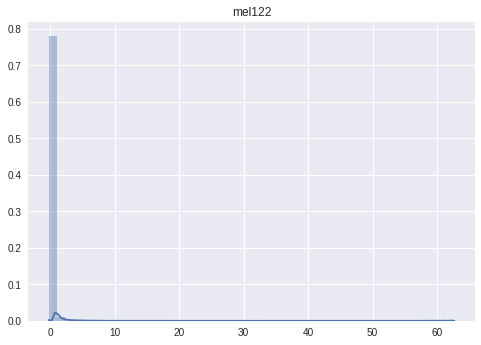

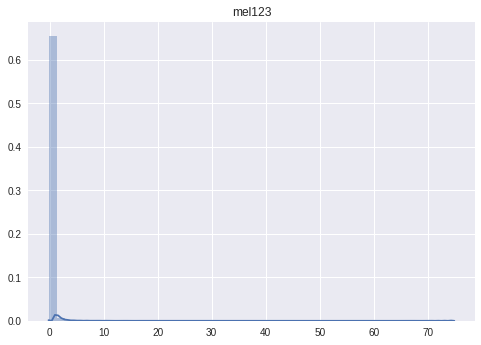

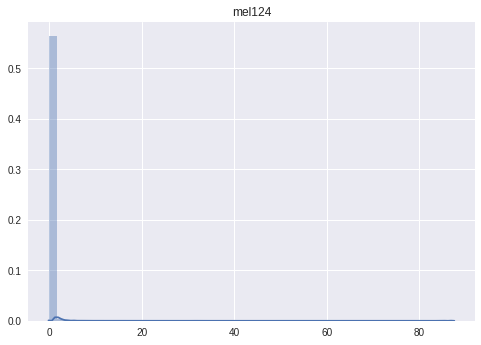

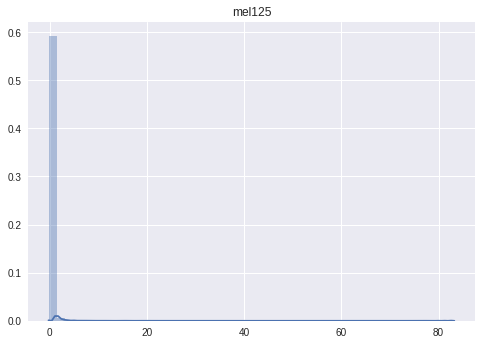

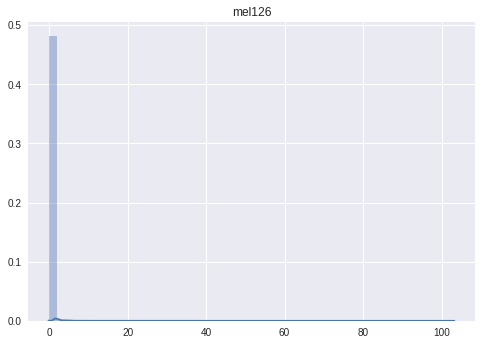

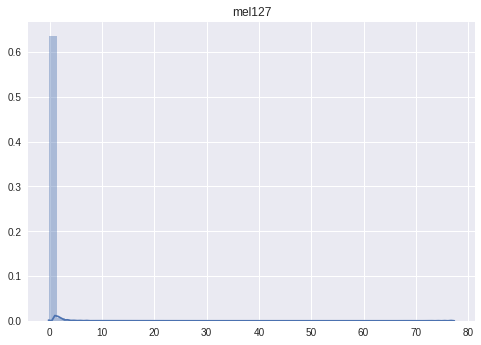

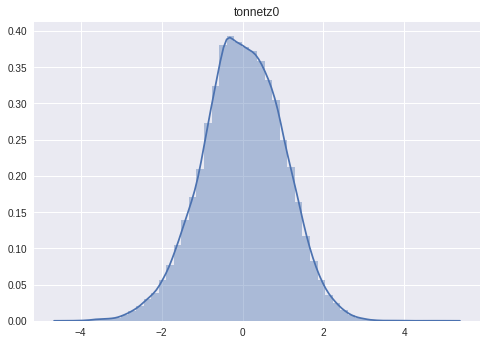

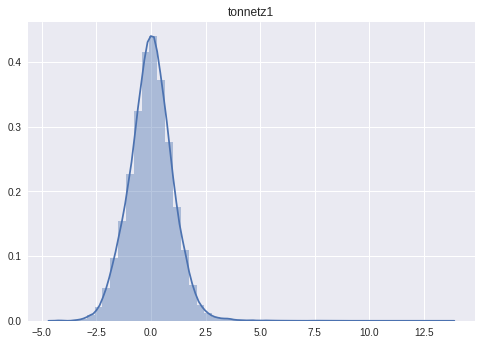

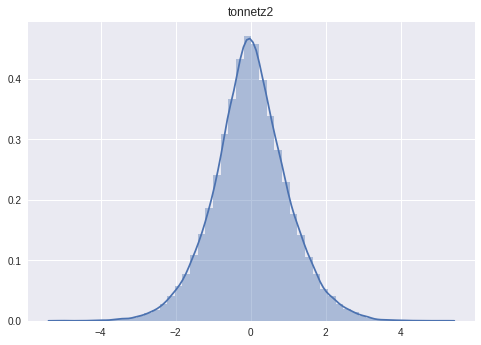

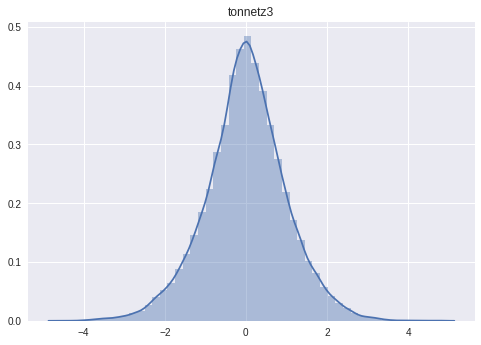

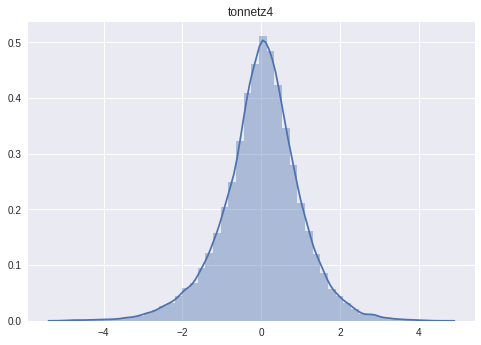

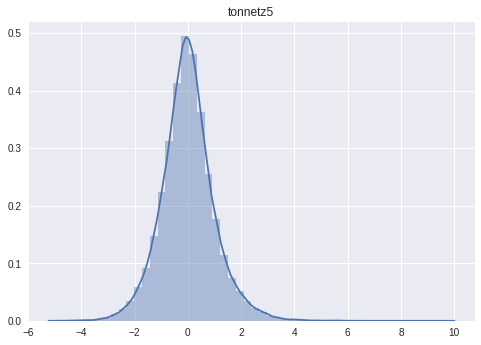

In [0]:
for i in range(X.shape[1]):
  plt.figure()
  sns.distplot(X[:,i])
  plt.title(data.columns[i])

In [0]:
X_train = X[:split_index]
X_test = X[split_index:]
y_train = y[:split_index]
y_test = y[split_index:]

In [0]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((47485, 167), (24453, 167), (47485, 8), (24453, 8))

## Model

Conv > Normalization > Activation > Dropout > Pooling

In [0]:
def get_model(x_shape, y_shape):
  model = models.Sequential()
  
  model.add(layers.Dense(256, input_shape=(x_shape,), kernel_regularizer=regularizers.l2(0.5)))
  model.add(layers.BatchNormalization())
  model.add(layers.Activation('relu'))
  model.add(layers.Dropout(0.5))
  
  model.add(layers.Dense(y_shape, activation='softmax'))
  
  model.compile(loss=losses.categorical_crossentropy, optimizer=optimizers.Adam(lr=0.00001), metrics=['accuracy'])
  return model


In [0]:
cbs = [callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=50, mode='auto', restore_best_weights=True)]

In [0]:
model = get_model(X_train.shape[1], y_train.shape[1])

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 256)               43008     
_________________________________________________________________
batch_normalization_6 (Batch (None, 256)               1024      
_________________________________________________________________
activation_6 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 2056      
Total params: 46,088
Trainable params: 45,576
Non-trainable params: 512
_________________________________________________________________


### Run

In [0]:
model = get_model(X_train.shape[1], y_train.shape[1])
history = model.fit(X_train,
                    y_train,
                    epochs=2000,
                    batch_size=1024,
                    validation_data=(X_test, y_test),
                    callbacks=cbs)

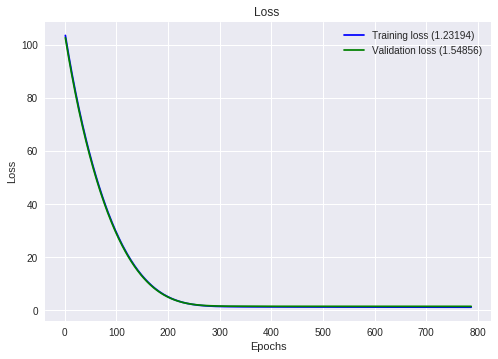

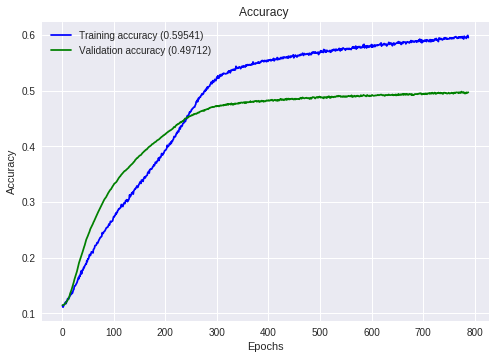

In [0]:
plot_history(history)

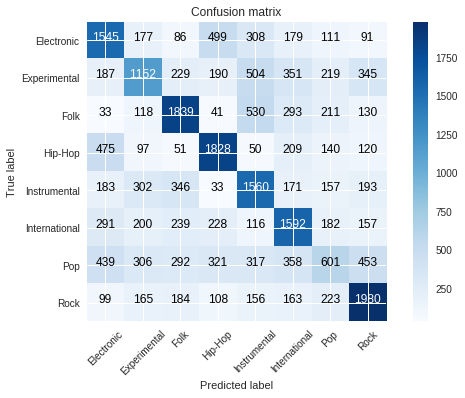

In [0]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1) 
y_test_classes = np.argmax(y_test, axis=1) 
confusion_mtx = confusion_matrix(y_test_classes, y_pred_classes)
plot_confusion_matrix(confusion_mtx, classes=encoder.classes_)

### Feature importance

In [0]:
my_model = KerasRegressor(build_fn=get_model,
  x_shape=X_train.shape[1], y_shape=y_train.shape[1],
  epochs=2000, batch_size=1024, validation_data=(X_test, y_test), callbacks=cbs)    
hist = my_model.fit(X_train, y_train)
perm = PermutationImportance(my_model, random_state=42).fit(X_train, y_train)

In [0]:
eli5.show_weights(perm, feature_names=data.columns[:-1].tolist(), top=None)

Weight,Feature
0.2363 ± 0.0026,spec_bw
0.1865 ± 0.0017,rmse
0.1458 ± 0.0040,mfcc1
0.1422 ± 0.0013,mfcc0
0.1095 ± 0.0022,mfcc3
0.0962 ± 0.0017,zcr
0.0934 ± 0.0030,spec_cent
0.0851 ± 0.0027,rolloff
0.0807 ± 0.0005,spec_contrast1
0.0792 ± 0.0019,spec_contrast4


In [0]:
plot_history(hist)

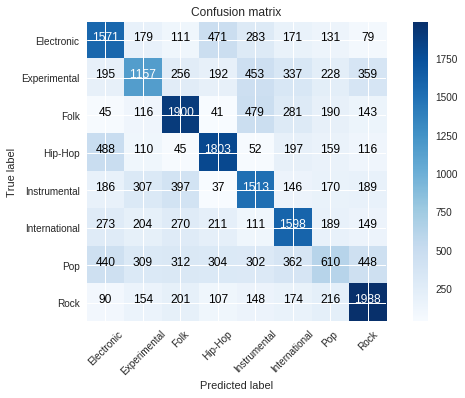

In [0]:
y_pred = my_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1) 
y_test_classes = np.argmax(y_test, axis=1) 
confusion_mtx = confusion_matrix(y_test_classes, y_pred_classes)
plot_confusion_matrix(confusion_mtx, classes=encoder.classes_)